In [2]:
import pickle
import pandas as pd
from scipy import stats
from multiprocessing import Pool
from statsmodels.stats.multitest import multipletests
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
import numpy as np
import h5py
import os
from scipy.stats import t as t_dist
from functools import partial
import warnings
warnings.filterwarnings('ignore')
import math
import re

In [4]:
chroms = ['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 
     'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 
          'chrX', 'chrY']

In [5]:
#TODO: сейчас(на 28 марта 2020 корреляции посчитаны с нефильтрофанной матрицей!!!)
with h5py.File("../all_marks/" + "methylation" + "/signal_matrix_outer.hdf5", 'r') as f:
    coords_str = f['coords'][:]

In [8]:
coords = makeTuplesFromCoords(coords_str)

In [9]:
df = pd.DataFrame(coords)

In [10]:
df.shape

(57556123, 3)

In [13]:
df.head()

0      1      2       3
0  chr1  10468  10469  peak_0
1  chr1  10469  10470  peak_1
2  chr1  10470  10471  peak_2
3  chr1  10471  10472  peak_3
4  chr1  10483  10484  peak_4

In [12]:
df[3] = ["peak_" + str(i) for i in range(0, 57556123)]

In [14]:
#Пики для метилирования
df.to_csv("../all_marks/methylation/merged_peaks_first_in_biosample.bed", sep="\t", index=None, header=None)

In [7]:
def makeTuplesFromCoords(coords):
    cds = []
    for c in coords:

        m = re.search("\(\'chr(\d+|[XYM])\'\,\s+(\d+)\,\s+(\d+)\)", c)
        if m is not None:
            cds.append(('chr' + str(m.group(1)), m.group(2), m.group(3)))
            
    return cds

In [7]:
splits = {}
chrom = ""
prev_chrom = None
for index, c in enumerate(cds):
    chrom = c[0]
    if(chrom not in splits.keys()):
        splits[chrom] = index
        if prev_chrom:
            splits[prev_chrom] = (splits[prev_chrom], index - 1)
        prev_chrom = chrom
        print(chrom + ": " + str(index))
splits[chrom] = (splits[chrom], len(cds) - 1)

chr1: 0
chr10: 4413852
chr11: 7031916
chr12: 9544728
chr13: 12048028
chr14: 13650522
chr15: 15309409
chr16: 16928767
chr17: 18989674
chr18: 21248447
chr19: 22586570
chr2: 24621006
chr20: 28784643
chr21: 30229805
chr22: 30945662
chr3: 32050852
chr4: 35232538
chr5: 38082515
chr6: 40967559
chr7: 43856405
chr8: 46847452
chr9: 49353173
chrM: 51606416
chrX: 51607230
chrY: 53918858


In [10]:
df = pd.DataFrame(data=data, index=coords, columns=files)
df_f = df.filter(regex="\(\'chr(\d+|[XYM])\'\,\s+(\d+)\,\s+(\d+)\)", axis=0)
df = pd.DataFrame(data=df_f.values, index=cds, columns=files)
df = df.reindex(sorted(df.columns), axis=1)

In [11]:
chroms_dfs = {}
for chrom in splits.keys():
    chroms_dfs[chrom] = df.iloc[splits[chrom][0]:splits[chrom][1]]

In [12]:
chroms_dfs['chr1'].shape

(4413851, 27)

In [ ]:
for chrom in chroms_dfs.keys():
    #makeCorrelations("methylation", 250, 5, chroms_dfs[chrom], chrom)
    with h5py.File("../all_marks/" + "methylation" + "/signal_matrix_" + chrom + ".hdf5", 'w') as f:
        f.create_dataset("signal_matrix", data=chroms_dfs[chrom].values)
        string_dt = h5py.special_dtype(vlen=str)
        f.create_dataset("files_names", data=np.array(files, dtype='object'), dtype=string_dt)
        
    with open("../all_marks/" + "methylation" + "/signal_matrix_" + chrom + "_coords.pickle", 'wb') as f:
        pickle.dump(chroms_dfs[chrom].index, f)

In [2]:
with h5py.File("../all_marks/" + "methylation" + "/signal_matrix_chr1.hdf5", 'r') as f:
    data = f['signal_matrix'][:]

In [18]:
for chrom in chroms:
    with h5py.File("../all_marks/" + "methylation" + "/signal_matrix_" + chrom + ".hdf5", 'r') as f:
        data = f['signal_matrix'][:]
    print("do " + chrom)
    makeCorrelations("methylation", 250, 1, data, chrom)

do chr1
Make matrices...
size: 476695908
3 chunks, make corrs in 1 threads...
done chunk 0
done chunk 1
done chunk 2
do chr10
Make matrices...
size: 282750804
3 chunks, make corrs in 1 threads...
done chunk 0
done chunk 1
done chunk 2
do chr11
Make matrices...
size: 271383588
3 chunks, make corrs in 1 threads...
done chunk 0
done chunk 1
done chunk 2
do chr12
Make matrices...
size: 270356292
3 chunks, make corrs in 1 threads...
done chunk 0
done chunk 1
done chunk 2
do chr13
Make matrices...
size: 173069244
3 chunks, make corrs in 1 threads...
done chunk 0
done chunk 1
done chunk 2
do chr14
Make matrices...
size: 179159688
3 chunks, make corrs in 1 threads...
done chunk 0
done chunk 1
done chunk 2
do chr15
Make matrices...
size: 174890556
3 chunks, make corrs in 1 threads...
done chunk 0
done chunk 1
done chunk 2
do chr16
Make matrices...
size: 222577848
3 chunks, make corrs in 1 threads...
done chunk 0
done chunk 1
done chunk 2
do chr17
Make matrices...
size: 243947376
3 chunks, make 

In [5]:
#Для метилирования
def makeCorrelationsMatrix_v2():
    lncRNA = pd.read_csv("../all_marks/"+ "methylation" + "/lncRNA_matrix_filtered_norm.csv", sep="\t", index_col=0)
    dof = lncRNA.shape[1] - 2
    chunk_size = 250
    lncRNAnames = lncRNA.index
    chunks = np.array_split(lncRNA.values, int(lncRNA.shape[0]/chunk_size) + 1)
    chunks_pos = np.cumsum([c.shape[0] for c in chunks])
    for i in range(4, len(chunks_pos)):
        print(str(i) + " chunk pos")
        dfs = []
        for j in np.array_split(range(0, chunks_pos[i] - (chunks_pos[i - 1] if i > 0 else 0)), 20):
            corrs = None
            print(str(j) + " chunk slice")
            for chrom in chroms:
                with h5py.File("../all_marks/" + "methylation" + "/lncRNA_Peaks_corrs/lncRNA_Peaks_Correlations_" + chrom + "_" + str(i) + '.hdf5', 'r') as f:
                    if corrs is not None:
                        corrs = np.concatenate((corrs, f['default'][j, :]), axis=1)
                    else:
                        corrs = f['default'][j, :]
            print("lncRNANames coords: " + str([k + (chunks_pos[i - 1] if i > 0 else 0) for k in j]))
            names = lncRNAnames[[k + (chunks_pos[i - 1] if i > 0 else 0) for k in j]]
            print(names)
            print(corrs.shape)
            signif_mask = testSignificance(corrs, dof)

            corrs[~signif_mask] = 0
            signif_mask = None
            zero_ind = np.where(~corrs.any(axis=1))[0]
            print("number of zero lncRNAs: " + str(len(zero_ind)))
            dfs.append(([n for k, n in enumerate(names) if k not in zero_ind], (corrs[~np.all(corrs == 0, axis=1)])))
    
        all_corrs = np.concatenate([d[1] for d in dfs])
        all_names = [item for sublist in [d[0] for d in dfs] for item in sublist]
        print("non zero lncRNAs: " + str(all_names))
        with h5py.File("../all_marks/" + "methylation" + "/lncRNA_Peaks_corrs/lncRNA_Peaks_Correlations_corrected_non_zero_" + str(i) + ".hdf5", 'w') as f:
            f.create_dataset("corrs_matrix", data=all_corrs)
            string_dt = h5py.special_dtype(vlen=str)
            f.create_dataset("lncRNAs_names", data=np.array(all_names, dtype='object'), dtype=string_dt)
            
        all_corrs = None
        all_names = None
        corrs = None
        dfs = None
        zero_ind = None

In [ ]:
dfs = makeCorrelationsMatrix_v2()

4 chunk pos
[ 0  1  2  3  4  5  6  7  8  9 10 11 12] chunk slice
lncRNANames coords: [973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985]
Index(['ENSG00000233527', 'ENSG00000233539', 'ENSG00000233547',
       'ENSG00000233554', 'ENSG00000233559', 'ENSG00000233593',
       'ENSG00000233602', 'ENSG00000233621', 'ENSG00000233665',
       'ENSG00000233672', 'ENSG00000233695', 'ENSG00000233705',
       'ENSG00000233723'],
      dtype='object')
(13, 57555285)
count t
count p-values
number of zero lncRNAs: 7
[13 14 15 16 17 18 19 20 21 22 23 24 25] chunk slice
lncRNANames coords: [986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998]
Index(['ENSG00000233725', 'ENSG00000233760', 'ENSG00000233766',
       'ENSG00000233791', 'ENSG00000233806', 'ENSG00000233817',
       'ENSG00000233834', 'ENSG00000233858', 'ENSG00000233862',
       'ENSG00000233871', 'ENSG00000233885', 'ENSG00000233901',
       'ENSG00000233912'],
      dtype='object')
(13, 57555285)
count t
count p-value

count t
count p-values
number of zero lncRNAs: 10
[207 208 209 210 211 212 213 214 215 216 217 218] chunk slice
lncRNANames coords: [1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191]
Index(['ENSG00000236833', 'ENSG00000236859', 'ENSG00000236882',
       'ENSG00000236901', 'ENSG00000236908', 'ENSG00000236914',
       'ENSG00000236977', 'ENSG00000237017', 'ENSG00000237036',
       'ENSG00000237037', 'ENSG00000237054', 'ENSG00000237101'],
      dtype='object')
(12, 57555285)
count t
count p-values
number of zero lncRNAs: 6
[219 220 221 222 223 224 225 226 227 228 229 230] chunk slice
lncRNANames coords: [1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203]
Index(['ENSG00000237125', 'ENSG00000237149', 'ENSG00000237181',
       'ENSG00000237187', 'ENSG00000237188', 'ENSG00000237222',
       'ENSG00000237232', 'ENSG00000237248', 'ENSG00000237280',
       'ENSG00000237298', 'ENSG00000237301', 'ENSG00000237310'],
      dtype='object')
(12, 57555285)
cou

count t
count p-values
number of zero lncRNAs: 8
[123 124 125 126 127 128 129 130 131 132 133 134] chunk slice
lncRNANames coords: [1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350]
Index(['ENSG00000241860', 'ENSG00000241886', 'ENSG00000241956',
       'ENSG00000241985', 'ENSG00000241990', 'ENSG00000242082',
       'ENSG00000242086', 'ENSG00000242094', 'ENSG00000242125',
       'ENSG00000242242', 'ENSG00000242258', 'ENSG00000242282'],
      dtype='object')
(12, 57555285)
count t
count p-values
number of zero lncRNAs: 7
[135 136 137 138 139 140 141 142 143 144 145 146] chunk slice
lncRNANames coords: [1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362]
Index(['ENSG00000242288', 'ENSG00000242396', 'ENSG00000242474',
       'ENSG00000242516', 'ENSG00000242539', 'ENSG00000242553',
       'ENSG00000242588', 'ENSG00000242622', 'ENSG00000242686',
       'ENSG00000242759', 'ENSG00000242791', 'ENSG00000242797'],
      dtype='object')
(12, 57555285)
coun

count t
count p-values
number of zero lncRNAs: 10
[39 40 41 42 43 44 45 46 47 48 49 50] chunk slice
lncRNANames coords: [1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509]
Index(['ENSG00000247011', 'ENSG00000247033', 'ENSG00000247081',
       'ENSG00000247092', 'ENSG00000247095', 'ENSG00000247121',
       'ENSG00000247134', 'ENSG00000247137', 'ENSG00000247151',
       'ENSG00000247157', 'ENSG00000247199', 'ENSG00000247240'],
      dtype='object')
(12, 57555285)
count t
count p-values
number of zero lncRNAs: 5
[51 52 53 54 55 56 57 58 59 60 61 62] chunk slice
lncRNANames coords: [1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521]
Index(['ENSG00000247271', 'ENSG00000247287', 'ENSG00000247317',
       'ENSG00000247324', 'ENSG00000247363', 'ENSG00000247373',
       'ENSG00000247400', 'ENSG00000247416', 'ENSG00000247498',
       'ENSG00000247516', 'ENSG00000247556', 'ENSG00000247572'],
      dtype='object')
(12, 57555285)
count t
count p-values
numb

count t
count p-values
number of zero lncRNAs: 5
non zero lncRNAs: ['ENSG00000246223', 'ENSG00000246339', 'ENSG00000246379', 'ENSG00000246526', 'ENSG00000246560', 'ENSG00000246582', 'ENSG00000246640', 'ENSG00000246695', 'ENSG00000246731', 'ENSG00000246889', 'ENSG00000247011', 'ENSG00000247033', 'ENSG00000247092', 'ENSG00000247134', 'ENSG00000247157', 'ENSG00000247199', 'ENSG00000247240', 'ENSG00000247416', 'ENSG00000247516', 'ENSG00000247624', 'ENSG00000247675', 'ENSG00000247765', 'ENSG00000247774', 'ENSG00000247970', 'ENSG00000247982', 'ENSG00000248019', 'ENSG00000248027', 'ENSG00000248049', 'ENSG00000248050', 'ENSG00000248161', 'ENSG00000248187', 'ENSG00000248206', 'ENSG00000248228', 'ENSG00000248265', 'ENSG00000248275', 'ENSG00000248441', 'ENSG00000248540', 'ENSG00000248587', 'ENSG00000248596', 'ENSG00000248682', 'ENSG00000248690', 'ENSG00000248774', 'ENSG00000248810', 'ENSG00000248874', 'ENSG00000248925', 'ENSG00000248980', 'ENSG00000248994', 'ENSG00000249021', 'ENSG00000249201', '

count t
count p-values
number of zero lncRNAs: 6
[159 160 161 162 163 164 165 166 167 168 169 170] chunk slice
lncRNANames coords: [1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872]
Index(['ENSG00000255036', 'ENSG00000255046', 'ENSG00000255052',
       'ENSG00000255081', 'ENSG00000255089', 'ENSG00000255097',
       'ENSG00000255121', 'ENSG00000255129', 'ENSG00000255135',
       'ENSG00000255139', 'ENSG00000255145', 'ENSG00000255153'],
      dtype='object')
(12, 57555285)
count t
count p-values
number of zero lncRNAs: 5
[171 172 173 174 175 176 177 178 179 180 181 182] chunk slice
lncRNANames coords: [1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884]
Index(['ENSG00000255158', 'ENSG00000255176', 'ENSG00000255182',
       'ENSG00000255197', 'ENSG00000255198', 'ENSG00000255224',
       'ENSG00000255234', 'ENSG00000255240', 'ENSG00000255248',
       'ENSG00000255284', 'ENSG00000255310', 'ENSG00000255326'],
      dtype='object')
(12, 57555285)
coun

count t
count p-values
number of zero lncRNAs: 8
[75 76 77 78 79 80 81 82 83 84 85 86] chunk slice
lncRNANames coords: [2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031]
Index(['ENSG00000258303', 'ENSG00000258325', 'ENSG00000258334',
       'ENSG00000258337', 'ENSG00000258354', 'ENSG00000258365',
       'ENSG00000258376', 'ENSG00000258377', 'ENSG00000258399',
       'ENSG00000258414', 'ENSG00000258430', 'ENSG00000258441'],
      dtype='object')
(12, 57555285)
count t
count p-values
number of zero lncRNAs: 6
[87 88 89 90 91 92 93 94 95 96 97 98] chunk slice
lncRNANames coords: [2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043]
Index(['ENSG00000258457', 'ENSG00000258458', 'ENSG00000258479',
       'ENSG00000258498', 'ENSG00000258525', 'ENSG00000258526',
       'ENSG00000258535', 'ENSG00000258545', 'ENSG00000258559',
       'ENSG00000258572', 'ENSG00000258593', 'ENSG00000258603'],
      dtype='object')
(12, 57555285)
count t
count p-values
numbe

In [3]:
#На входе маскированные массивы(потому что в них могут быть nan'ы)
def vcorrcoef(target, X, prefix, corr_file_name, data):
    chunk_index = data[0]
    Y = data[1]
    Xm = np.reshape(np.mean(X,axis=1),(X.shape[0],1))
    Ym = np.reshape(np.mean(Y,axis=1),(Y.shape[0],1))
    r_num = (X-Xm).dot((Y-Ym).T)
    r_den = np.sqrt(np.sum((X-Xm)**2,axis=1)[:, np.newaxis]).dot(np.sqrt(np.sum((Y-Ym)**2,axis=1))[:, np.newaxis].T)
    r = r_num/r_den

    with h5py.File("../all_marks/" + target + "/lncRNA_Peaks_corrs/" + corr_file_name + prefix + "_" + str(chunk_index) + '.hdf5', 'w') as f:
        dset = f.create_dataset("default", data=r.data.T)
        
    print("done chunk " + str(chunk_index))
    return chunk_index

In [4]:
#По хорошему надо делать свою реализацию ф-ций sf и fdr_bh векторизованные
def testSignificance(data, dof):
    
    def FDR(data):
        return np.array(multipletests(data, alpha=0.05, method='fdr_bh')[0])
    
    t = data * np.sqrt((dof/((data+1.0)*(1.0-data))).clip(0))
    print("count t")
    prob = 2 * t_dist.sf(np.abs(t), dof)
    t = None
    print("count p-values")
    return np.apply_along_axis(FDR, 1, prob)#Boolean mask

In [4]:
def testSignificance_v2(data, dof):
    t = data * np.sqrt((dof/((data+1.0)*(1.0-data))).clip(0))
    #print("count t")
    prob = 2 * t_dist.sf(np.abs(t), dof)
    t = None
    #print("count p-values")
    return multipletests(prob, alpha=0.05, method='fdr_bh')[0]#Boolean mask

In [22]:
df = pd.read_csv("../all_marks/"+ "H3K27me3" + "/lncRNA_matrix_filtered_norm.csv", sep="\t", index_col=0)

In [23]:
signal = pd.read_csv("../all_marks/"+ "H3K27me3" + "/narrow_2_peaks_signal_matrix_norm.csv", sep="\t", index_col=0)

In [5]:
def makeCorrelations(target, chunk_size, threads_num, signal_file_name, corr_file_name, data=None, prefix=""): 
    
    lncRNA = pd.read_csv("../all_marks/"+ target + "/lncRNA_matrix_filtered_norm.csv", sep="\t", index_col=0)
    if(data is not None):
        chip = data
    else:
        chip = pd.read_csv("../all_marks/" + target + "/" + signal_file_name, sep="\t", index_col=0).values
    
    print("Make matrices...")
    X = stats.mstats.rankdata(np.ma.masked_invalid(chip), axis=1)
    X = X.astype('float32')
    X[X == 0] = np.nan
    X -= 1
    X = np.ma.array(X, mask=np.isnan(X))
    print("size: " + str(X.nbytes))
    chip = None
    
    Y = stats.mstats.rankdata(np.ma.masked_invalid(lncRNA.values), axis=1)
    Y = Y.astype('float32')
    Y[Y == 0] = np.nan
    Y -= 1
    Y = np.ma.array(Y, mask=np.isnan(Y))
    
    chunks = np.array_split(Y, int(Y.shape[0]/chunk_size) + 1)
    chunks_pos = np.cumsum([c.shape[0] for c in chunks])
    print(str(len(chunks_pos)) + " chunks, make corrs in " + str(threads_num) + " threads...")
    
    if not os.path.exists("../all_marks/" + target + "/lncRNA_Peaks_corrs/"):
        os.makedirs("../all_marks/" + target + "/lncRNA_Peaks_corrs/")
        
    func = partial(vcorrcoef, target, X, prefix, corr_file_name)
    
    pool = Pool(processes=threads_num)
    corr = pool.map(func, enumerate(chunks))

    pool.close()
    pool.join()

In [6]:
makeCorrelations("H3K27me3", 250, 5, "narrow_2_peaks_signal_matrix_norm.csv", "lncRNA_narrow_2_Peaks_Correlations")

Make matrices...
size: 165070800
25 chunks, make corrs in 5 threads...
done chunk 2
done chunk 0
done chunk 6
done chunk 4
done chunk 8
done chunk 3
done chunk 1
done chunk 7
done chunk 9
done chunk 5
done chunk 10
done chunk 12
done chunk 14
done chunk 16
done chunk 18
done chunk 11
done chunk 13
done chunk 15
done chunk 17
done chunk 19
done chunk 20
done chunk 22
done chunk 24
done chunk 21
done chunk 23


In [7]:
def makeCorrelationsMatrix(target, chunk_size, signal_file_name, corr_file_name):
    i = 0
    dfs = []
    lncRNA = pd.read_csv("../all_marks/"+ target + "/lncRNA_matrix_filtered_norm.csv", sep="\t", index_col=0)
    chip = pd.read_csv("../all_marks/" + target + "/" + signal_file_name, sep="\t", index_col=0)
    dof = lncRNA.shape[1] - 2
    lncRNAnames = lncRNA.index
    chunks = np.array_split(lncRNA.values, int(lncRNA.shape[0]/chunk_size) + 1)
    chunks_pos = np.cumsum([c.shape[0] for c in chunks])
    print(str(len(chunks_pos)))
    for i in range(0, len(chunks_pos)):
        with h5py.File("../all_marks/" + target + "/lncRNA_Peaks_corrs/" + corr_file_name + "_" + str(i) + '.hdf5', 'r') as f:
            data = f['default'][:]
            names = lncRNAnames[(chunks_pos[i - 1] if i > 0 else 0):chunks_pos[i]]

            signif_mask = testSignificance(data, dof)

            data[~signif_mask] = 0
            signif_mask = None
            zero_ind = np.where(~data.any(axis=1))[0]

            dfs.append(([n for i, n in enumerate(names) if i not in zero_ind], (data[~np.all(data == 0, axis=1)])))
    
    all_corrs = np.concatenate([i[1] for i in dfs])
    all_names = [item for sublist in [i[0] for i in dfs] for item in sublist]
        
    with h5py.File("../all_marks/" + target + "/lncRNA_Peaks_corrs/" + corr_file_name + "_corrected_non_zero.hdf5", 'w') as f:
        f.create_dataset("corrs_matrix", data=all_corrs)
        string_dt = h5py.special_dtype(vlen=str)
        f.create_dataset("lncRNAs_names", data=np.array(all_names, dtype='object'), dtype=string_dt)

In [8]:
makeCorrelationsMatrix("H3K27me3", 250, "narrow_2_peaks_signal_matrix_norm.csv", "lncRNA_narrow_2_Peaks_Correlations")

25
count t
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values


In [11]:
makeCorrelationsMatrix("H3K27me3", 250, "narrow_peaks_signal_matrix_norm.csv", "lncRNA_narrow_Peaks_Correlations")

25
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values


In [11]:
with h5py.File("../all_marks/" + "H3K27me3" + "/lncRNA_Peaks_corrs/lncRNA_narrow_2_Peaks_Correlations_corrected_non_zero.hdf5", 'r') as f:
    lncRNAs = f['lncRNAs_names'][:]

In [12]:
len(lncRNAs)

1522

In [15]:
lncRNAs

array(['ENSG00000103472', 'ENSG00000116883', 'ENSG00000117242', ...,
       'ENSG00000283045', 'ENSG00000283103', 'ENSG00000283122'],
      dtype=object)

In [16]:
'ENSG00000103472' in lncRNAs

True

In [19]:
def check_lncRNA_corrs_existing(lncRNA, exclude_marks = []):
    for target in targets + [('methylation', '')]:
        if target[0] in exclude_marks:
            continue
        if target[0] == 'methylation':  
            for chunk_number in range(0, 19):
                with h5py.File("../all_marks/" + target[0] + "/lncRNA_Peaks_corrs/lncRNA_Peaks_Correlations_corrected_non_zero" + ("_" + str(chunk_number) if chunk_number!=None else "") + ".hdf5", 'r') as f:
                    lncRNAs = f['lncRNAs_names'][:]

                    if lncRNA in lncRNAs:
                        print("Found in " + target[0] + str(chunk_number))
                    else:
                        print("Not found in " + target[0] + str(chunk_number))
        else:
            with h5py.File("../all_marks/" + target[0] + "/lncRNA_Peaks_corrs/lncRNA_Peaks_Correlations_corrected_non_zero.hdf5", 'r') as f:
                lncRNAs = f['lncRNAs_names'][:]

                if lncRNA in lncRNAs:
                    print("Found in " + target[0])
                else:
                    print("Not found in " + target[0])

In [ ]:
check_lncRNA_corrs_existing('')

In [15]:
lncRNAs = []
with h5py.File("../all_marks/" + "H3K27me3" + "/lncRNA_Peaks_corrs/lncRNA_broad_2_Peaks_Correlations_corrected_non_zero.hdf5", 'r') as f:
    corrs = f['corrs_matrix'][:]
    lncRNAs = lncRNAs + list(f['lncRNAs_names'][:])

In [16]:
flat = corrs.flatten()

In [17]:
nonzero_idx = flat.nonzero()[0]

In [18]:
nonzero_corrs = flat[nonzero_idx]

In [19]:
corrs.shape

(1498, 908484)

In [20]:
len(nonzero_corrs)

8744809

In [21]:
rcParams['figure.figsize'] = 11.7,8.27
rcParams["patch.force_edgecolor"] = True
sns.set(color_codes=True)

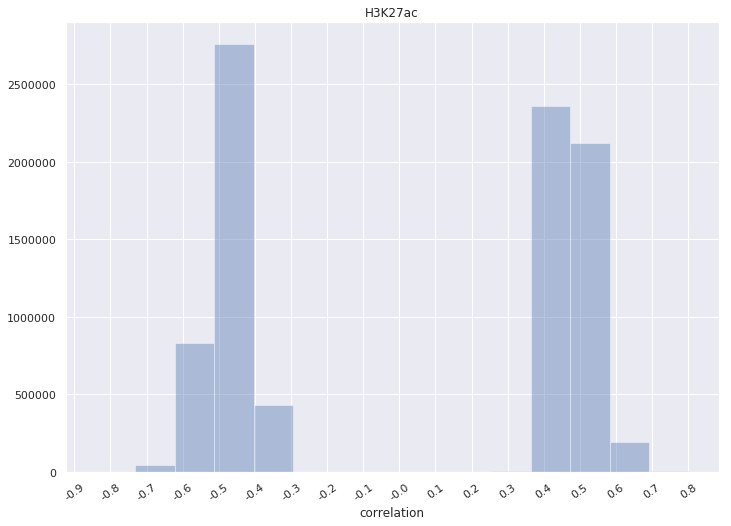

In [22]:
ax = sns.distplot(nonzero_corrs, bins=15, kde=False)
ax.set_title("H3K27ac")
ax.set_xticks(np.arange(-0.9, 0.9, 0.1))
#ax.set_yticks(range(0, 70001, 10000))
ax.set_xticklabels(np.around(ax.get_xticks(), decimals=2), rotation=35)
ax.set(xlabel='correlation')
plt.show()

In [30]:
fig = ax.get_figure()
fig.patch.set_alpha(0)
fig.savefig("../all_marks/H3K27ac/plots/LncRNAs_correlations_hist.png", bbox_inches='tight', pad_inches = 0)

In [2]:
targets = [("H3K27ac", "_narrow"), ("H3K27me3", ""), ("H3K36me3", ""), 
           ("H3K4me1", "_narrow"), ("H3K4me2", "_narrow"), ("H3K4me3", "_narrow"), ("H3K79me2", ""), 
           ("H3K9ac", "_narrow"), ("H3K9me3", ""), ("H4K20me1", "")]

In [ ]:
for target in targets:
    chunk_size = 1000
    print("Make correlations for " + target[0] + "...")
    makeCorrelations(target[0], chunk_size, 5)
    makeCorrelationsMatrix(target[0], chunk_size)

In [7]:
makeCorrelationsMatrix("H3K27me3", 1000)

count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values
count t
count p-values


In [146]:
def checkCorrsInPairs(target, fantom_only=False):
    print("target " + target)
    
    with h5py.File("../all_marks/" + target + "/lncRNA_Peaks_corrs/lncRNA_Peaks_Correlations_corrected_non_zero.hdf5", 'r') as f:
        corrs = f['corrs_matrix'][:]
        lncRNAs = f['lncRNAs_names'][:]
    
    if(fantom_only):
        fantom_lncRNAs = pd.read_csv("../all_marks/" + target + "/our_fantom_genes_association_pvalues.tsv", sep="\t")['lncRNAId'].tolist()
        lncRNAs = list(set(fantom_lncRNAs).intersection(set(lncRNAs)))
        print(str(len(fantom_lncRNAs)) + " in phantom and " + str(len(lncRNAs)) + " after filtering")
    
    anno = pd.read_csv("../all_marks/" + target + "/peaks_anno.csv", sep="\t")
    anno['feature'] = [i.split('.')[0] for i in anno['feature']]
    chip = pd.read_csv("../all_marks/" + target + "/peaks_signal_matrix_norm.csv", sep="\t", index_col=0)
    rna = pd.read_csv("../all_marks/" + target + "/rna_matrix_norm.csv", sep="\t", index_col=0)
    rna.index = [i.split(".")[0] for i in rna.index]
    
    #откуда такая разница?(между encode списком и gencode аннотацией)
    common_genes = set(rna.index).intersection(set([i.split('.')[0] for i in anno['feature']]))
    rna = rna.loc[common_genes]
    anno = anno[anno['feature'].isin(common_genes)]
    
    gcp_corrs = {}
    for i, lncRNA in enumerate(lncRNAs):
        peaks_names = ["peak_" + str(j) for j in np.nonzero(corrs[i, :])[0]]
        anno_tmp = anno[anno['peak'].isin(peaks_names)]
        print(lncRNA + " number " + str(i) + " has " + str(len(peaks_names)) + " peaks, in annotation " + str(anno_tmp.shape[0]) + " rows for " + str(len(anno_tmp['feature'].unique())) + " genes")
        
        if(anno_tmp.shape[0] == 0):
            continue 
        
        #print("Make matrices...")
        X = stats.mstats.rankdata(chip.loc[anno_tmp['peak']].values, axis=1)
        X = X.astype('float32')

        Y = stats.mstats.rankdata(rna.loc[anno_tmp['feature']].values, axis=1)
        Y = Y.astype('float32')

        #print("Make corrs...")
        #Векторизованная корреляция
        Xm = np.reshape(np.mean(X,axis=1),(X.shape[0],1))
        Ym = np.reshape(np.mean(Y,axis=1),(Y.shape[0],1))
        r_num = np.sum((X-Xm)*(Y-Ym), axis=1)
        r_den = np.sqrt(np.sum((X-Xm)**2, axis=1))*np.sqrt(np.sum((Y-Ym)**2,axis=1))
        corr = r_num/r_den

        #print("Make significance...")
        signif_mask = testSignificance_v2(corr, chip.shape[1] - 2)
        corr[~signif_mask] = 0

        #Передаем все(в том числе нулевые(т.е. не прошедшие тест)) корреляции чтобы потом если надо найти ген(и пик)
        gcp_corrs[lncRNA] = corr
    corrs = None  
    return gcp_corrs

In [84]:
for target in targets:
    gcp_corrs = checkCorrsInPairs(target[0], True)
    
    with open('../all_marks/' + target[0] + '/gcp_corrs.pickle', 'wb') as f:
        pickle.dump(gcp_corrs, f)

target H3K27ac
23 in phantom and 23 after filtering
ENSG00000233117 number 0 has 1 peaks, in annotation 1 rows for 1 genes
ENSG00000225733 number 1 has 38 peaks, in annotation 46 rows for 45 genes
ENSG00000256268 number 2 has 756 peaks, in annotation 569 rows for 497 genes
ENSG00000268895 number 3 has 60 peaks, in annotation 54 rows for 54 genes
ENSG00000233396 number 4 has 3340 peaks, in annotation 2717 rows for 1928 genes
ENSG00000212978 number 5 has 23260 peaks, in annotation 22231 rows for 9037 genes
ENSG00000227053 number 6 has 1 peaks, in annotation 0 rows for 0 genes
ENSG00000257219 number 7 has 1 peaks, in annotation 2 rows for 2 genes
ENSG00000230630 number 8 has 900 peaks, in annotation 700 rows for 605 genes
ENSG00000227036 number 9 has 25 peaks, in annotation 22 rows for 21 genes
ENSG00000234456 number 10 has 1126 peaks, in annotation 992 rows for 773 genes
ENSG00000253161 number 11 has 16 peaks, in annotation 16 rows for 15 genes
ENSG00000214548 number 12 has 1714 peaks, i

target H3K79me2
9 in phantom and 9 after filtering
ENSG00000229647 number 0 has 103 peaks, in annotation 89 rows for 88 genes
ENSG00000221817 number 1 has 18 peaks, in annotation 21 rows for 21 genes
ENSG00000215039 number 2 has 2 peaks, in annotation 1 rows for 1 genes
ENSG00000233117 number 3 has 8 peaks, in annotation 4 rows for 4 genes
ENSG00000227053 number 4 has 29 peaks, in annotation 30 rows for 29 genes
ENSG00000212978 number 5 has 208 peaks, in annotation 219 rows for 192 genes
ENSG00000246430 number 6 has 2412 peaks, in annotation 2709 rows for 2097 genes
ENSG00000214548 number 7 has 774 peaks, in annotation 618 rows for 497 genes
ENSG00000257219 number 8 has 1 peaks, in annotation 1 rows for 1 genes
target H3K9ac
11 in phantom and 11 after filtering
ENSG00000230630 number 0 has 2 peaks, in annotation 2 rows for 2 genes
ENSG00000221817 number 1 has 6 peaks, in annotation 4 rows for 4 genes
ENSG00000233117 number 2 has 1 peaks, in annotation 1 rows for 1 genes
ENSG00000204054

In [141]:
def GCPCorrsPicture(target):
    with open('../all_marks/' + target + '/gcp_corrs.pickle', 'rb') as f:
        t = pickle.load(f)
        
    for l, corr in t.items():
        print(l + " len: " + str(len(corr)) +  " nonzero elems: " + str(len([i for i in corr if i != 0])))
        
    for_picture = {}
    for l, corr in t.items():
        if len([i for i in corr if i != 0]) == 0:
            continue
        for_picture[l] = corr[np.nonzero(corr)[0]]
        
    i = 1
    fig = plt.figure()
    rcParams['figure.figsize'] = 10,10
    for l, corrs in for_picture.items():
        if(target == "H3K27me3"):
            ax1 = fig.add_subplot(2,2,i)
        elif(target == "H3K79me2"):
            ax1 = fig.add_subplot(2,3,i)
        elif(target == "H3K9ac"):
            ax1 = fig.add_subplot(3,3,i)
        elif(target == "H3K9me3" or target == "H4K20me1"):
            ax1 = fig.add_subplot(1,2,i)
        else:
            ax1 = fig.add_subplot(math.ceil(len(for_picture.keys())/4),4,i)
        sns.distplot(corrs, kde=False, bins=10, ax=ax1).set_title(l)
        i = i + 1
    fig.tight_layout()
    plt.show()

H3K27ac
ENSG00000233117 len: 1 nonzero elems: 0
ENSG00000225733 len: 46 nonzero elems: 12
ENSG00000256268 len: 569 nonzero elems: 203
ENSG00000268895 len: 54 nonzero elems: 19
ENSG00000233396 len: 2717 nonzero elems: 1258
ENSG00000212978 len: 22231 nonzero elems: 5053
ENSG00000257219 len: 2 nonzero elems: 0
ENSG00000230630 len: 700 nonzero elems: 294
ENSG00000227036 len: 22 nonzero elems: 9
ENSG00000234456 len: 992 nonzero elems: 422
ENSG00000253161 len: 16 nonzero elems: 4
ENSG00000214548 len: 1461 nonzero elems: 616
ENSG00000229647 len: 2909 nonzero elems: 470
ENSG00000229852 len: 1 nonzero elems: 0
ENSG00000234608 len: 30808 nonzero elems: 10753
ENSG00000271270 len: 37809 nonzero elems: 9854
ENSG00000205181 len: 76 nonzero elems: 24
ENSG00000246430 len: 1265 nonzero elems: 600
ENSG00000204054 len: 1982 nonzero elems: 976
ENSG00000223485 len: 26050 nonzero elems: 9612
ENSG00000240875 len: 15001 nonzero elems: 5199
ENSG00000260032 len: 1 nonzero elems: 1


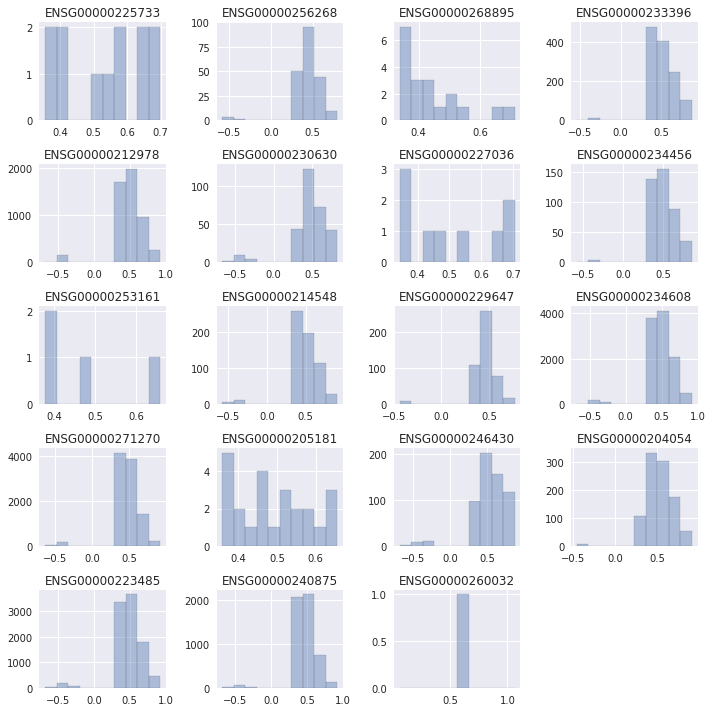

H3K27me3
ENSG00000253161 len: 5 nonzero elems: 3
ENSG00000212978 len: 365 nonzero elems: 69
ENSG00000256268 len: 4 nonzero elems: 0
ENSG00000233396 len: 1 nonzero elems: 0
ENSG00000246273 len: 4339 nonzero elems: 390
ENSG00000246430 len: 43 nonzero elems: 14


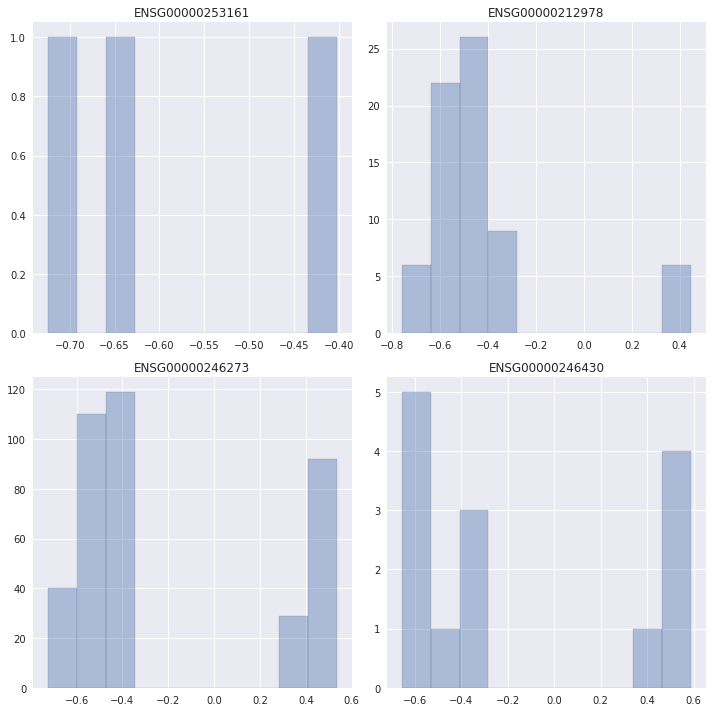

H3K36me3
ENSG00000229647 len: 45 nonzero elems: 19
ENSG00000253161 len: 9541 nonzero elems: 2162
ENSG00000234608 len: 1169 nonzero elems: 649
ENSG00000267577 len: 2 nonzero elems: 0
ENSG00000256268 len: 3 nonzero elems: 3
ENSG00000223485 len: 7 nonzero elems: 3
ENSG00000268895 len: 1123 nonzero elems: 341
ENSG00000227053 len: 2 nonzero elems: 0
ENSG00000212978 len: 3827 nonzero elems: 2078
ENSG00000270069 len: 36197 nonzero elems: 6009
ENSG00000257219 len: 49 nonzero elems: 34


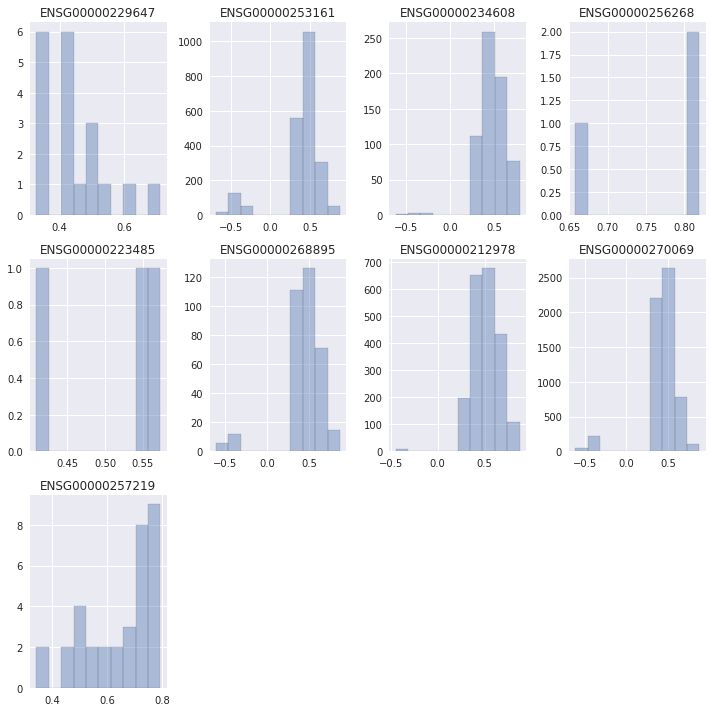

H3K4me1
ENSG00000230630 len: 1146 nonzero elems: 334
ENSG00000229647 len: 3 nonzero elems: 2
ENSG00000254682 len: 1358 nonzero elems: 628
ENSG00000204054 len: 12573 nonzero elems: 4124
ENSG00000233117 len: 1 nonzero elems: 1
ENSG00000234608 len: 9819 nonzero elems: 2749
ENSG00000225733 len: 2658 nonzero elems: 1109
ENSG00000256268 len: 4888 nonzero elems: 1258
ENSG00000212978 len: 34994 nonzero elems: 9274
ENSG00000223485 len: 474 nonzero elems: 198
ENSG00000268895 len: 1 nonzero elems: 0
ENSG00000240875 len: 1 nonzero elems: 1
ENSG00000233396 len: 15399 nonzero elems: 3034
ENSG00000251580 len: 7371 nonzero elems: 1981
ENSG00000253161 len: 36 nonzero elems: 20
ENSG00000246430 len: 2085 nonzero elems: 1053
ENSG00000214548 len: 1 nonzero elems: 0
ENSG00000257219 len: 122868 nonzero elems: 24068


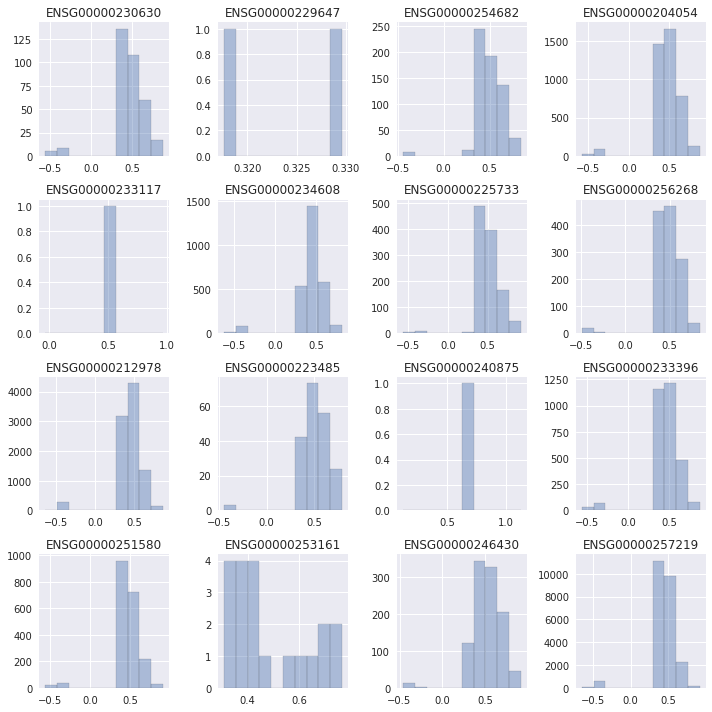

H3K4me2
ENSG00000254682 len: 3 nonzero elems: 0
ENSG00000233117 len: 1 nonzero elems: 0
ENSG00000237187 len: 1 nonzero elems: 0
ENSG00000246067 len: 11367 nonzero elems: 2608
ENSG00000256268 len: 1 nonzero elems: 0
ENSG00000231312 len: 3 nonzero elems: 0
ENSG00000212978 len: 10227 nonzero elems: 2121
ENSG00000230630 len: 1594 nonzero elems: 122
ENSG00000234546 len: 2341 nonzero elems: 393
ENSG00000227036 len: 2 nonzero elems: 1
ENSG00000203721 len: 31464 nonzero elems: 5220
ENSG00000253161 len: 28133 nonzero elems: 2246
ENSG00000223478 len: 31702 nonzero elems: 2739
ENSG00000270069 len: 129 nonzero elems: 18
ENSG00000204054 len: 3 nonzero elems: 0
ENSG00000240875 len: 8 nonzero elems: 0
ENSG00000251580 len: 2 nonzero elems: 1
ENSG00000246273 len: 65 nonzero elems: 2
ENSG00000225439 len: 440 nonzero elems: 89
ENSG00000260032 len: 3 nonzero elems: 0


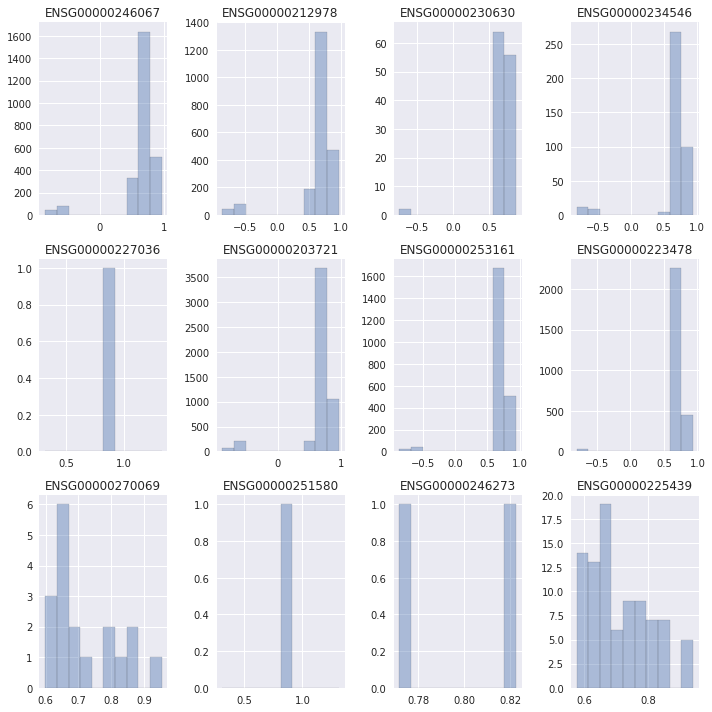

H3K4me3
ENSG00000233117 len: 44 nonzero elems: 18
ENSG00000246067 len: 7 nonzero elems: 2
ENSG00000225733 len: 28206 nonzero elems: 7033
ENSG00000256268 len: 1237 nonzero elems: 722
ENSG00000268895 len: 149 nonzero elems: 33
ENSG00000241990 len: 59 nonzero elems: 36
ENSG00000233396 len: 113 nonzero elems: 66
ENSG00000212978 len: 1 nonzero elems: 0
ENSG00000242147 len: 75 nonzero elems: 39
ENSG00000257219 len: 111033 nonzero elems: 18107
ENSG00000230630 len: 5 nonzero elems: 4
ENSG00000226950 len: 55 nonzero elems: 8
ENSG00000238266 len: 2 nonzero elems: 2
ENSG00000214548 len: 191450 nonzero elems: 20692
ENSG00000229647 len: 216526 nonzero elems: 20998
ENSG00000234608 len: 547 nonzero elems: 267
ENSG00000223478 len: 6695 nonzero elems: 2534
ENSG00000223485 len: 212035 nonzero elems: 27632
ENSG00000246273 len: 120 nonzero elems: 78


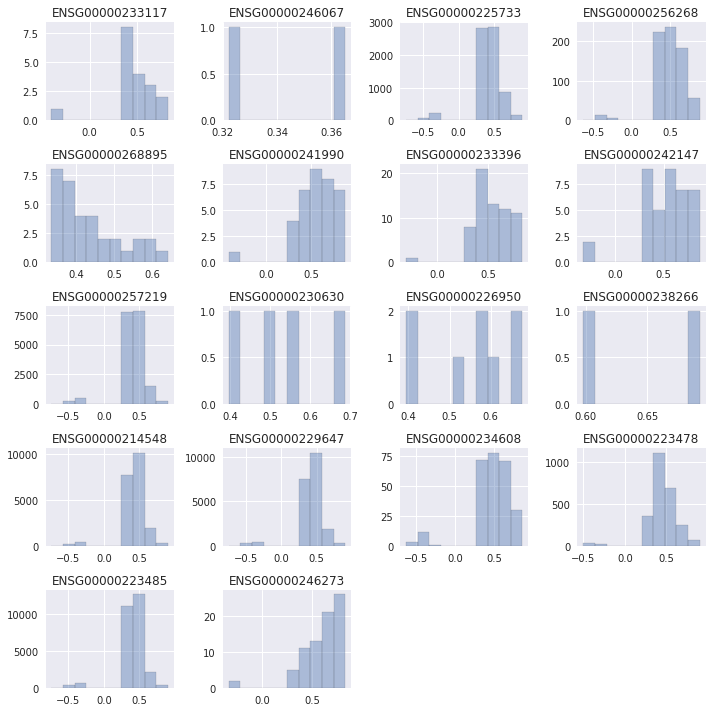

H3K79me2
ENSG00000229647 len: 89 nonzero elems: 0
ENSG00000221817 len: 21 nonzero elems: 8
ENSG00000215039 len: 1 nonzero elems: 0
ENSG00000233117 len: 4 nonzero elems: 1
ENSG00000227053 len: 30 nonzero elems: 16
ENSG00000212978 len: 219 nonzero elems: 77
ENSG00000246430 len: 2709 nonzero elems: 1162
ENSG00000214548 len: 618 nonzero elems: 179
ENSG00000257219 len: 1 nonzero elems: 0


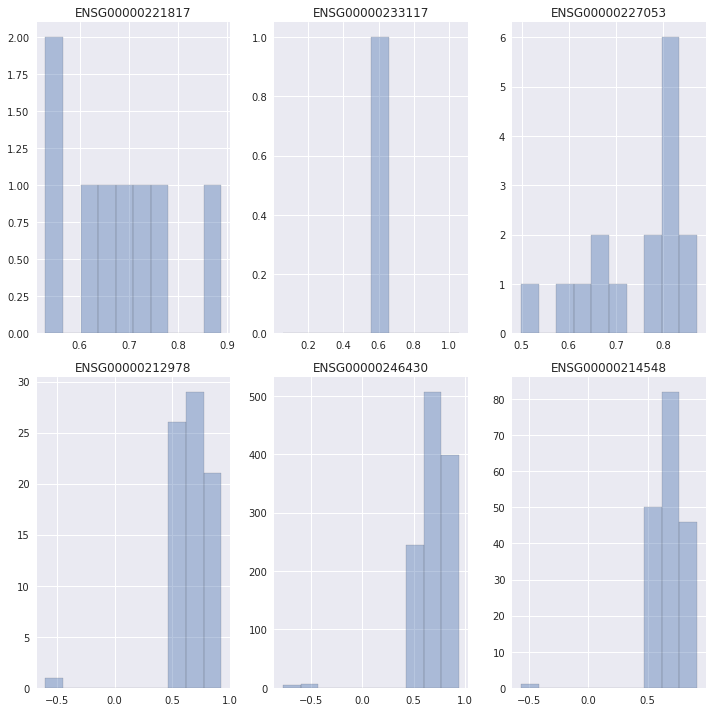

H3K9ac
ENSG00000230630 len: 2 nonzero elems: 0
ENSG00000221817 len: 4 nonzero elems: 0
ENSG00000233117 len: 1 nonzero elems: 0
ENSG00000204054 len: 2 nonzero elems: 0
ENSG00000227036 len: 1 nonzero elems: 1
ENSG00000225733 len: 1489 nonzero elems: 464
ENSG00000212978 len: 1 nonzero elems: 1
ENSG00000240875 len: 2 nonzero elems: 1
ENSG00000246273 len: 1 nonzero elems: 1
ENSG00000257219 len: 1273 nonzero elems: 414
ENSG00000260032 len: 2 nonzero elems: 1


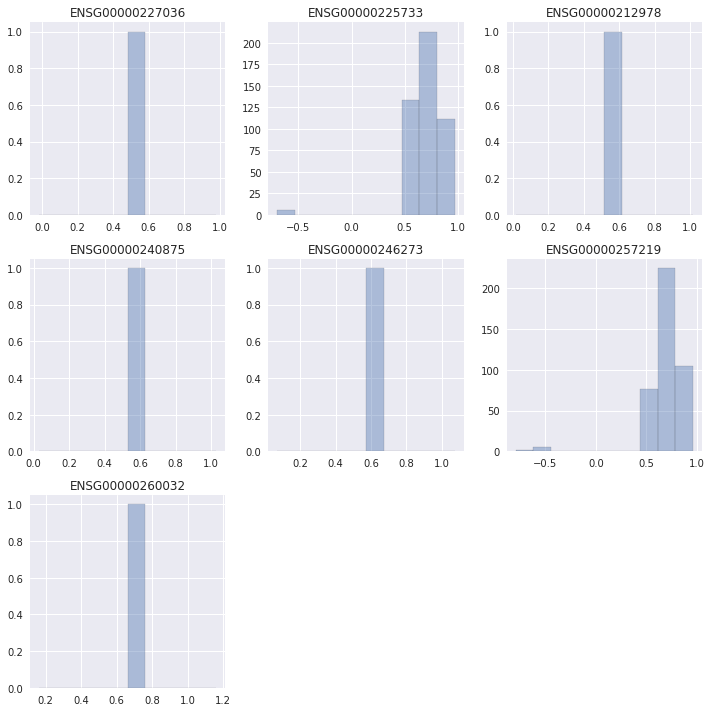

H3K9me3
ENSG00000230630 len: 13 nonzero elems: 0
ENSG00000233117 len: 64 nonzero elems: 12
ENSG00000234608 len: 1 nonzero elems: 0
ENSG00000229847 len: 2 nonzero elems: 0
ENSG00000227053 len: 302 nonzero elems: 24


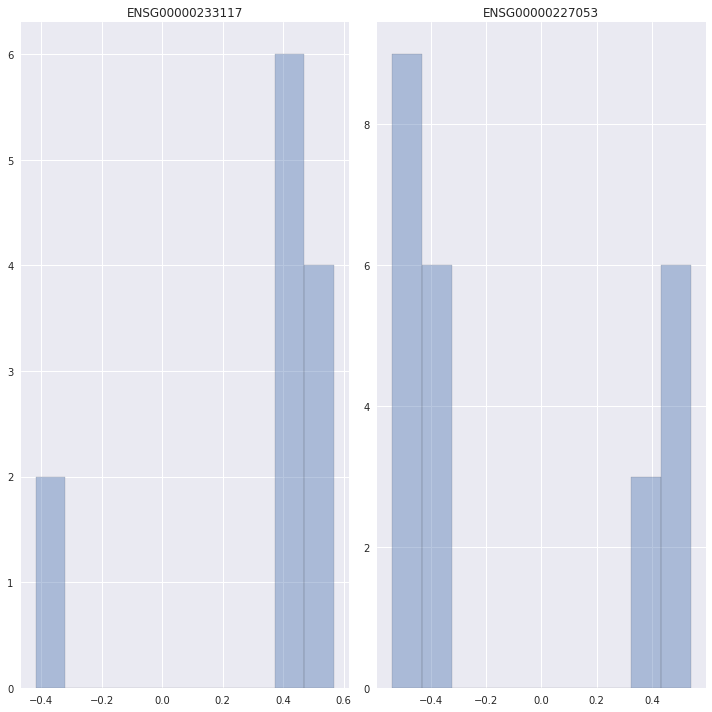

H4K20me1
ENSG00000230630 len: 1 nonzero elems: 0
ENSG00000225733 len: 1 nonzero elems: 1
ENSG00000234456 len: 2 nonzero elems: 0
ENSG00000233901 len: 231 nonzero elems: 89


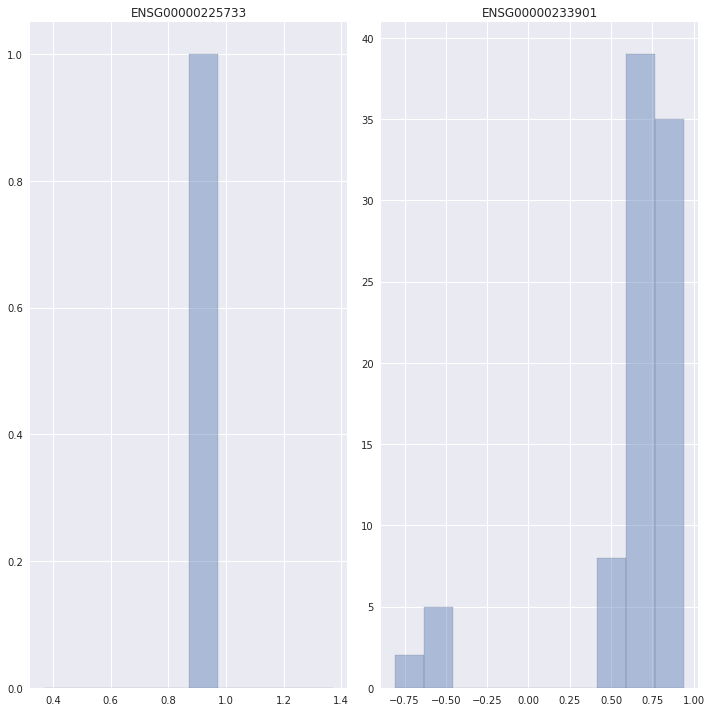

In [142]:
for target in targets:
    print(target[0])
    GCPCorrsPicture(target[0])

In [ ]:
#========================================== графики ====================================================================

In [10]:
configPlots()

In [175]:
#TODO: разбить пики на хромосомы, строить для каждой такую картинку, сохранятся кластеры?
#А те что получились, о чем говорят?(может это уже разбиение на хромосомы?) или это доступность хроматина?
#Построить только для фантомовских lncRNA, если увидим соответствующие паттерны(типа та рнк, которая значимо
#ставит метку, у нее больше красного и проч(а у тех что не значимы нету), 
#то можно говорить о других РНК, которых нет в фантоме)
#А в какие кластеры попадут фантомовские рнк?(которые значимые оказались)
#TODO: Кластеризовать гены, а не пики
#TODO: Кластеризовать раздельно разреженные РНК и плотные РНК
def printClusterHitmap(target, dnsample, fantom_only=False):
    
    def downsample(lncRNArow):
        #return [-1 if i < 0 else 1 if i > 0 else 0 for i in lncRNArow.reshape(-1, 500).mean(axis=1)]
        return lncRNArow.reshape(-1, dnsample).sum(axis=1)
    
    with h5py.File("../all_marks/" + target + "/lncRNA_Peaks_corrs/lncRNA_Peaks_Correlations_corrected_non_zero.hdf5", 'r') as f:
        corrs = f['corrs_matrix'][:]
        lncRNAs = list(f['lncRNAs_names'][:])
        
    if(fantom_only):
        fantom_lncRNAs = pd.read_csv("../all_marks/" + target + "/our_fantom_genes_association_pvalues.tsv", sep="\t")['lncRNAId'].tolist()
        print(list(enumerate(fantom_lncRNAs)))
        corrs = corrs[[lncRNAs.index(i) for i in set(fantom_lncRNAs).intersection(set(lncRNAs))], :]
        
    print(corrs.shape)    
    corrs = np.pad(corrs, [(0, 0), (0, (dnsample - corrs.shape[1]%dnsample))], mode='constant')
    ds_corrs = np.apply_along_axis(downsample, 1, corrs)
    
    mask = np.zeros_like(ds_corrs)
    mask[ds_corrs == 0] = True
    with sns.axes_style("white"):
        ax = sns.clustermap(ds_corrs, mask=mask, cmap="coolwarm", vmax=10, vmin=-10, figsize=(17, 10), 
                            col_cluster=False, method="weighted", metric="correlation")

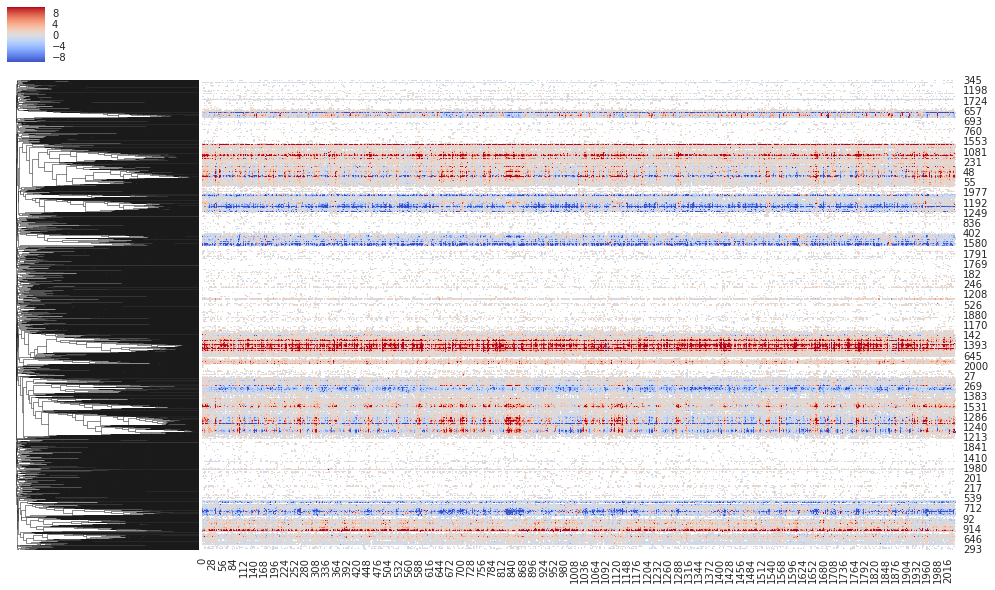

In [150]:
printClusterHitmap("H3K27ac", 500)

[(0, 'ENSG00000233117'), (1, 'ENSG00000212978'), (2, 'ENSG00000260032'), (3, 'ENSG00000223485'), (4, 'ENSG00000271270'), (5, 'ENSG00000253161'), (6, 'ENSG00000268895'), (7, 'ENSG00000227053'), (8, 'ENSG00000225733'), (9, 'ENSG00000240875'), (10, 'ENSG00000234456'), (11, 'ENSG00000234608'), (12, 'ENSG00000256268'), (13, 'ENSG00000230630'), (14, 'ENSG00000246430'), (15, 'ENSG00000214548'), (16, 'ENSG00000233396'), (17, 'ENSG00000204054'), (18, 'ENSG00000229852'), (19, 'ENSG00000205181'), (20, 'ENSG00000257219'), (21, 'ENSG00000227036'), (22, 'ENSG00000229647')]
(23, 1018625)


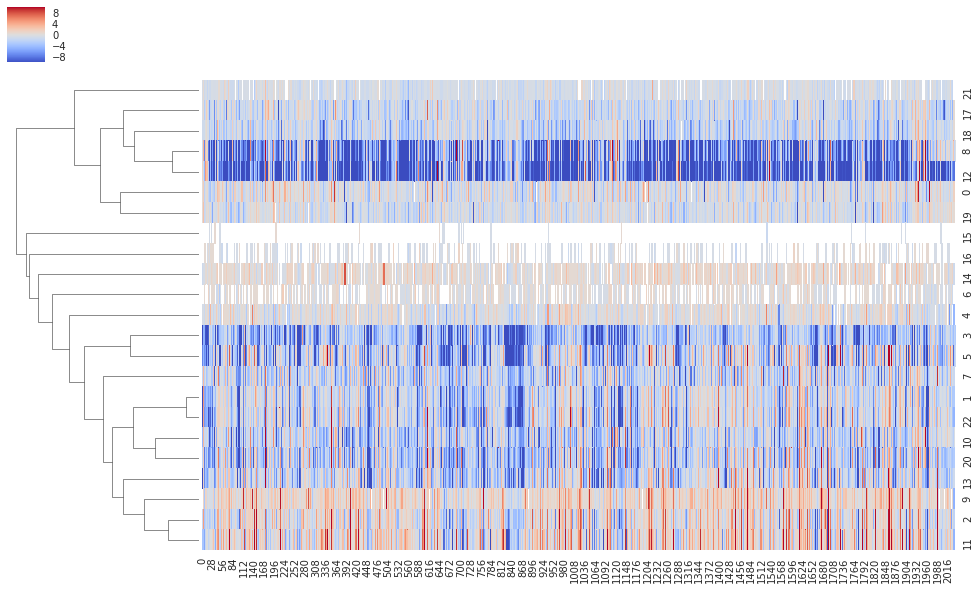

In [176]:
printClusterHitmap("H3K27ac", 500, True)

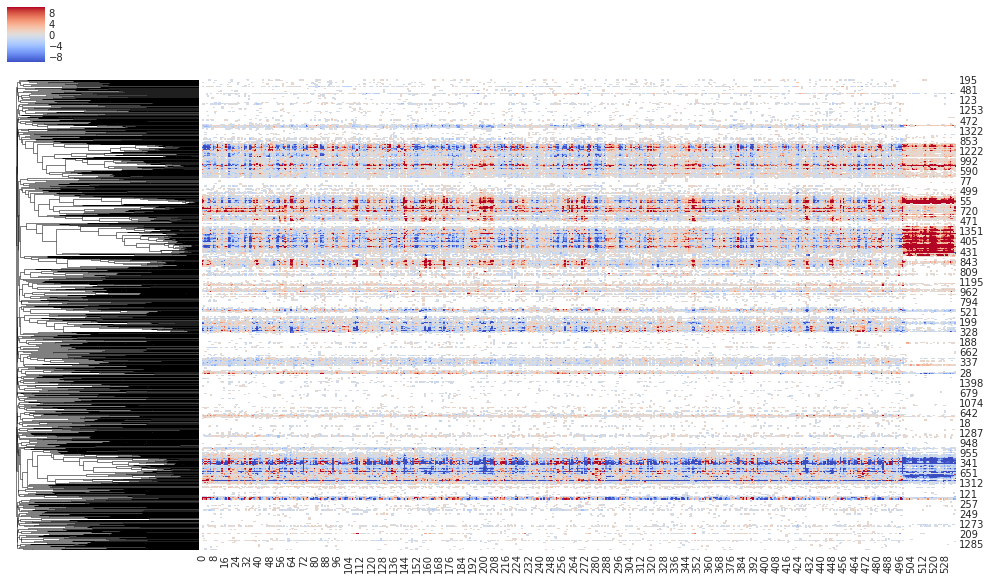

In [23]:
printClusterHitmap("H3K27me3", 500)

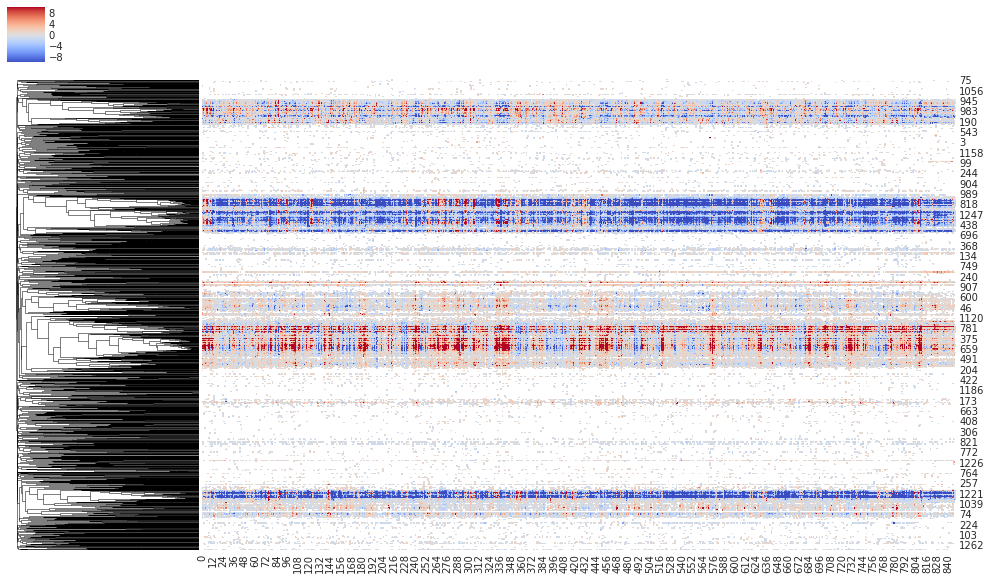

In [9]:
printClusterHitmap("H3K36me3")

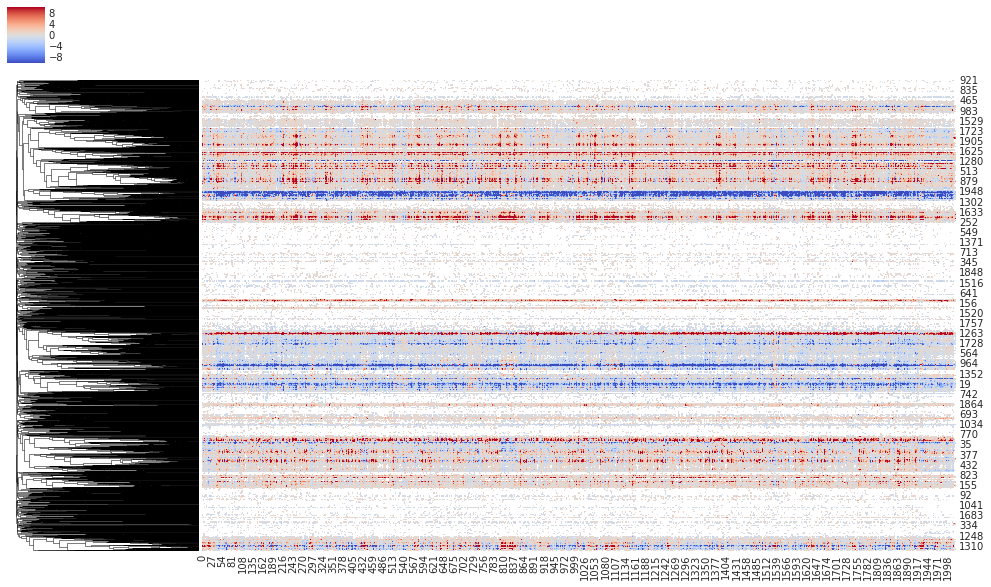

In [10]:
printClusterHitmap("H3K4me1")

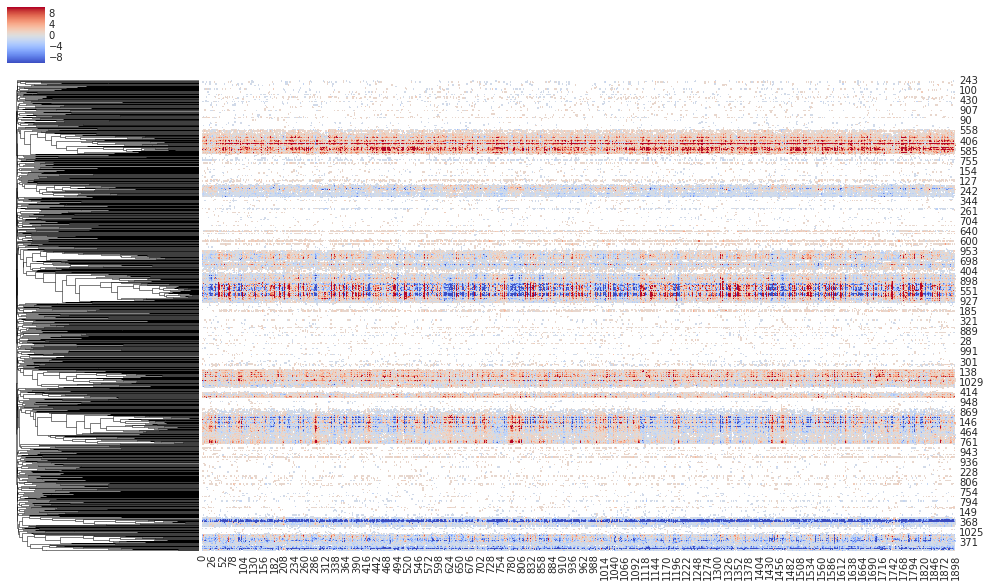

In [11]:
printClusterHitmap("H3K4me2")

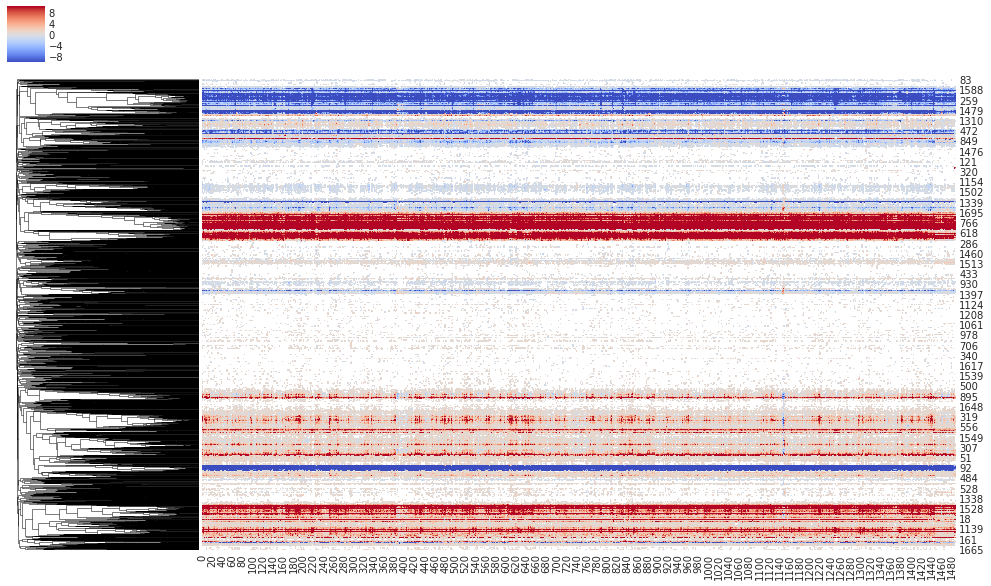

In [12]:
printClusterHitmap("H3K4me3")

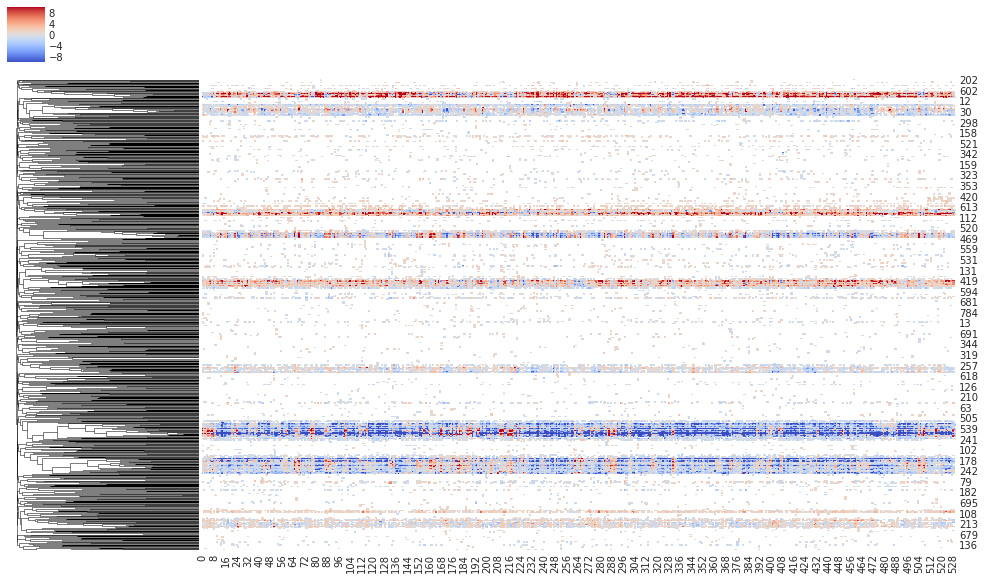

In [13]:
printClusterHitmap("H3K79me2")               

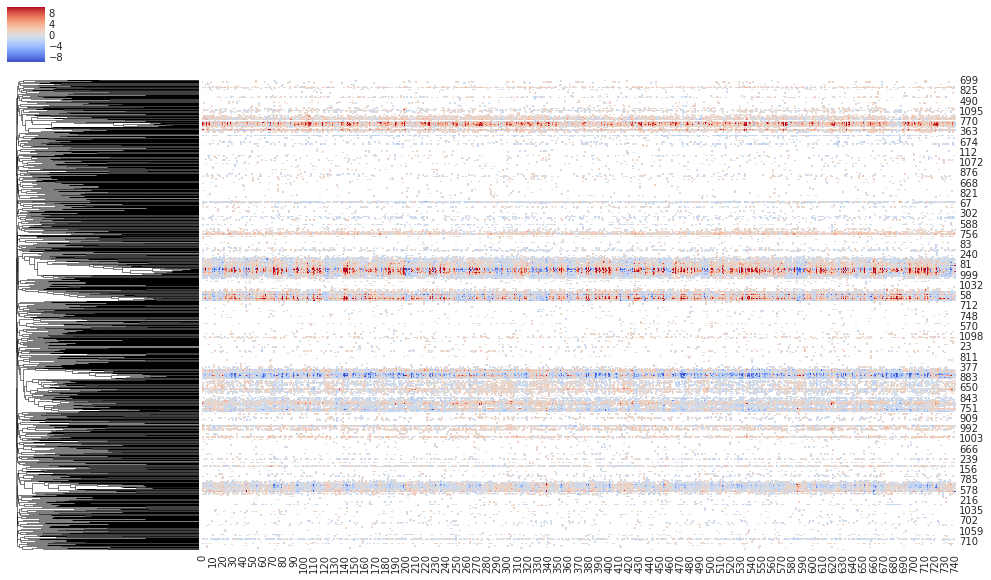

In [14]:
printClusterHitmap("H3K9ac")

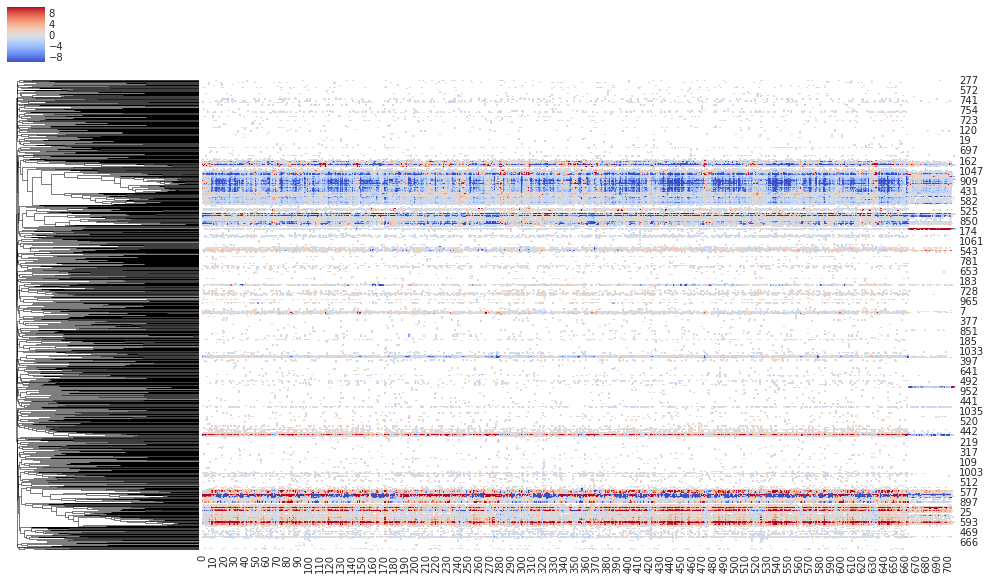

In [15]:
printClusterHitmap("H3K9me3")

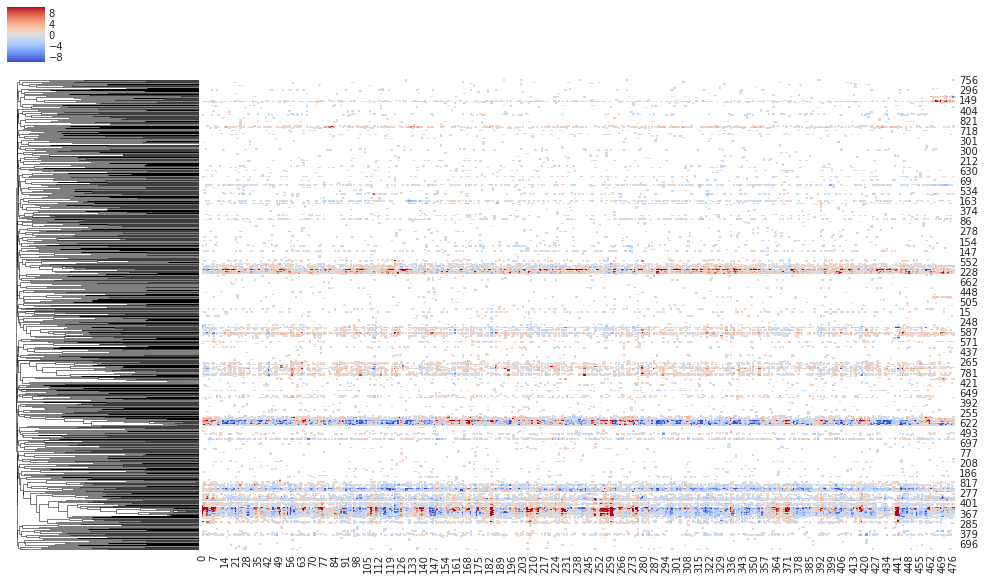

In [16]:
printClusterHitmap("H4K20me1")

In [19]:
def getCorrs(target):
    with h5py.File("../all_marks/" + target + "/lncRNA_Peaks_corrs/lncRNA_Peaks_Correlations_corrected_non_zero.hdf5", 'r') as f:
            corrs = f['corrs_matrix'][:]
    f = corrs.flatten()
    return f[f.nonzero()[0]]

In [9]:
def configPlots():
    sns.set(color_codes=True)
    rcParams['figure.figsize'] = 11.7,8.27
    rcParams["patch.force_edgecolor"] = True

In [37]:
def allMarksHists():
    
    sns.set(color_codes=True)
    rcParams['figure.figsize'] = 25,50
    rcParams["patch.force_edgecolor"] = True
    
    fig = plt.figure()
    for i, target in enumerate(targets):
        corrrelationsHist(target[0], fig.add_subplot(5, 2, i + 1), False)
        print(target[0])
    plt.show()
    
    fig.patch.set_alpha(0)
    fig.savefig("../all_marks/Correlations_hist.png", bbox_inches='tight', pad_inches = 0)

In [38]:
def corrrelationsHist(target, ax, save):
    
    sns.distplot(getCorrs(target), bins=16, kde=False, ax=ax)
    #ax.set_yticks(range(0, 2500001, 250000))
    #ax.set_xticks(np.arange(-0.7, 0.75, 0.1))
    ax.set_xticklabels([x for x in ax.get_xticks()], rotation=30, fontsize=14)
    ax.set_yticklabels([y for y in ax.get_yticks()], fontsize=14)
    ax.set_xlabel('correlation', fontsize=14)
    ax.set_title(target, fontsize=14)
    #plt.show()
    
    if not os.path.exists("../all_marks/" + target + "/plots/"):
        os.makedirs("../all_marks/" + target + "/plots/")
    
    #save
    if save:
        fig = ax.get_figure()
        fig.patch.set_alpha(0)
        fig.savefig("../all_marks/" + target + "/plots/MakeLncRNAWithPeaksCorrelations_correlations_hist.png", bbox_inches='tight', pad_inches = 0)

/home/mazurovev/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


H3K27ac


/home/mazurovev/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


H3K27me3


/home/mazurovev/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


H3K36me3


/home/mazurovev/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


H3K4me1


/home/mazurovev/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


H3K4me2


/home/mazurovev/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


H3K4me3


/home/mazurovev/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


H3K79me2


/home/mazurovev/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


H3K9ac


/home/mazurovev/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


H3K9me3


/home/mazurovev/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


H4K20me1


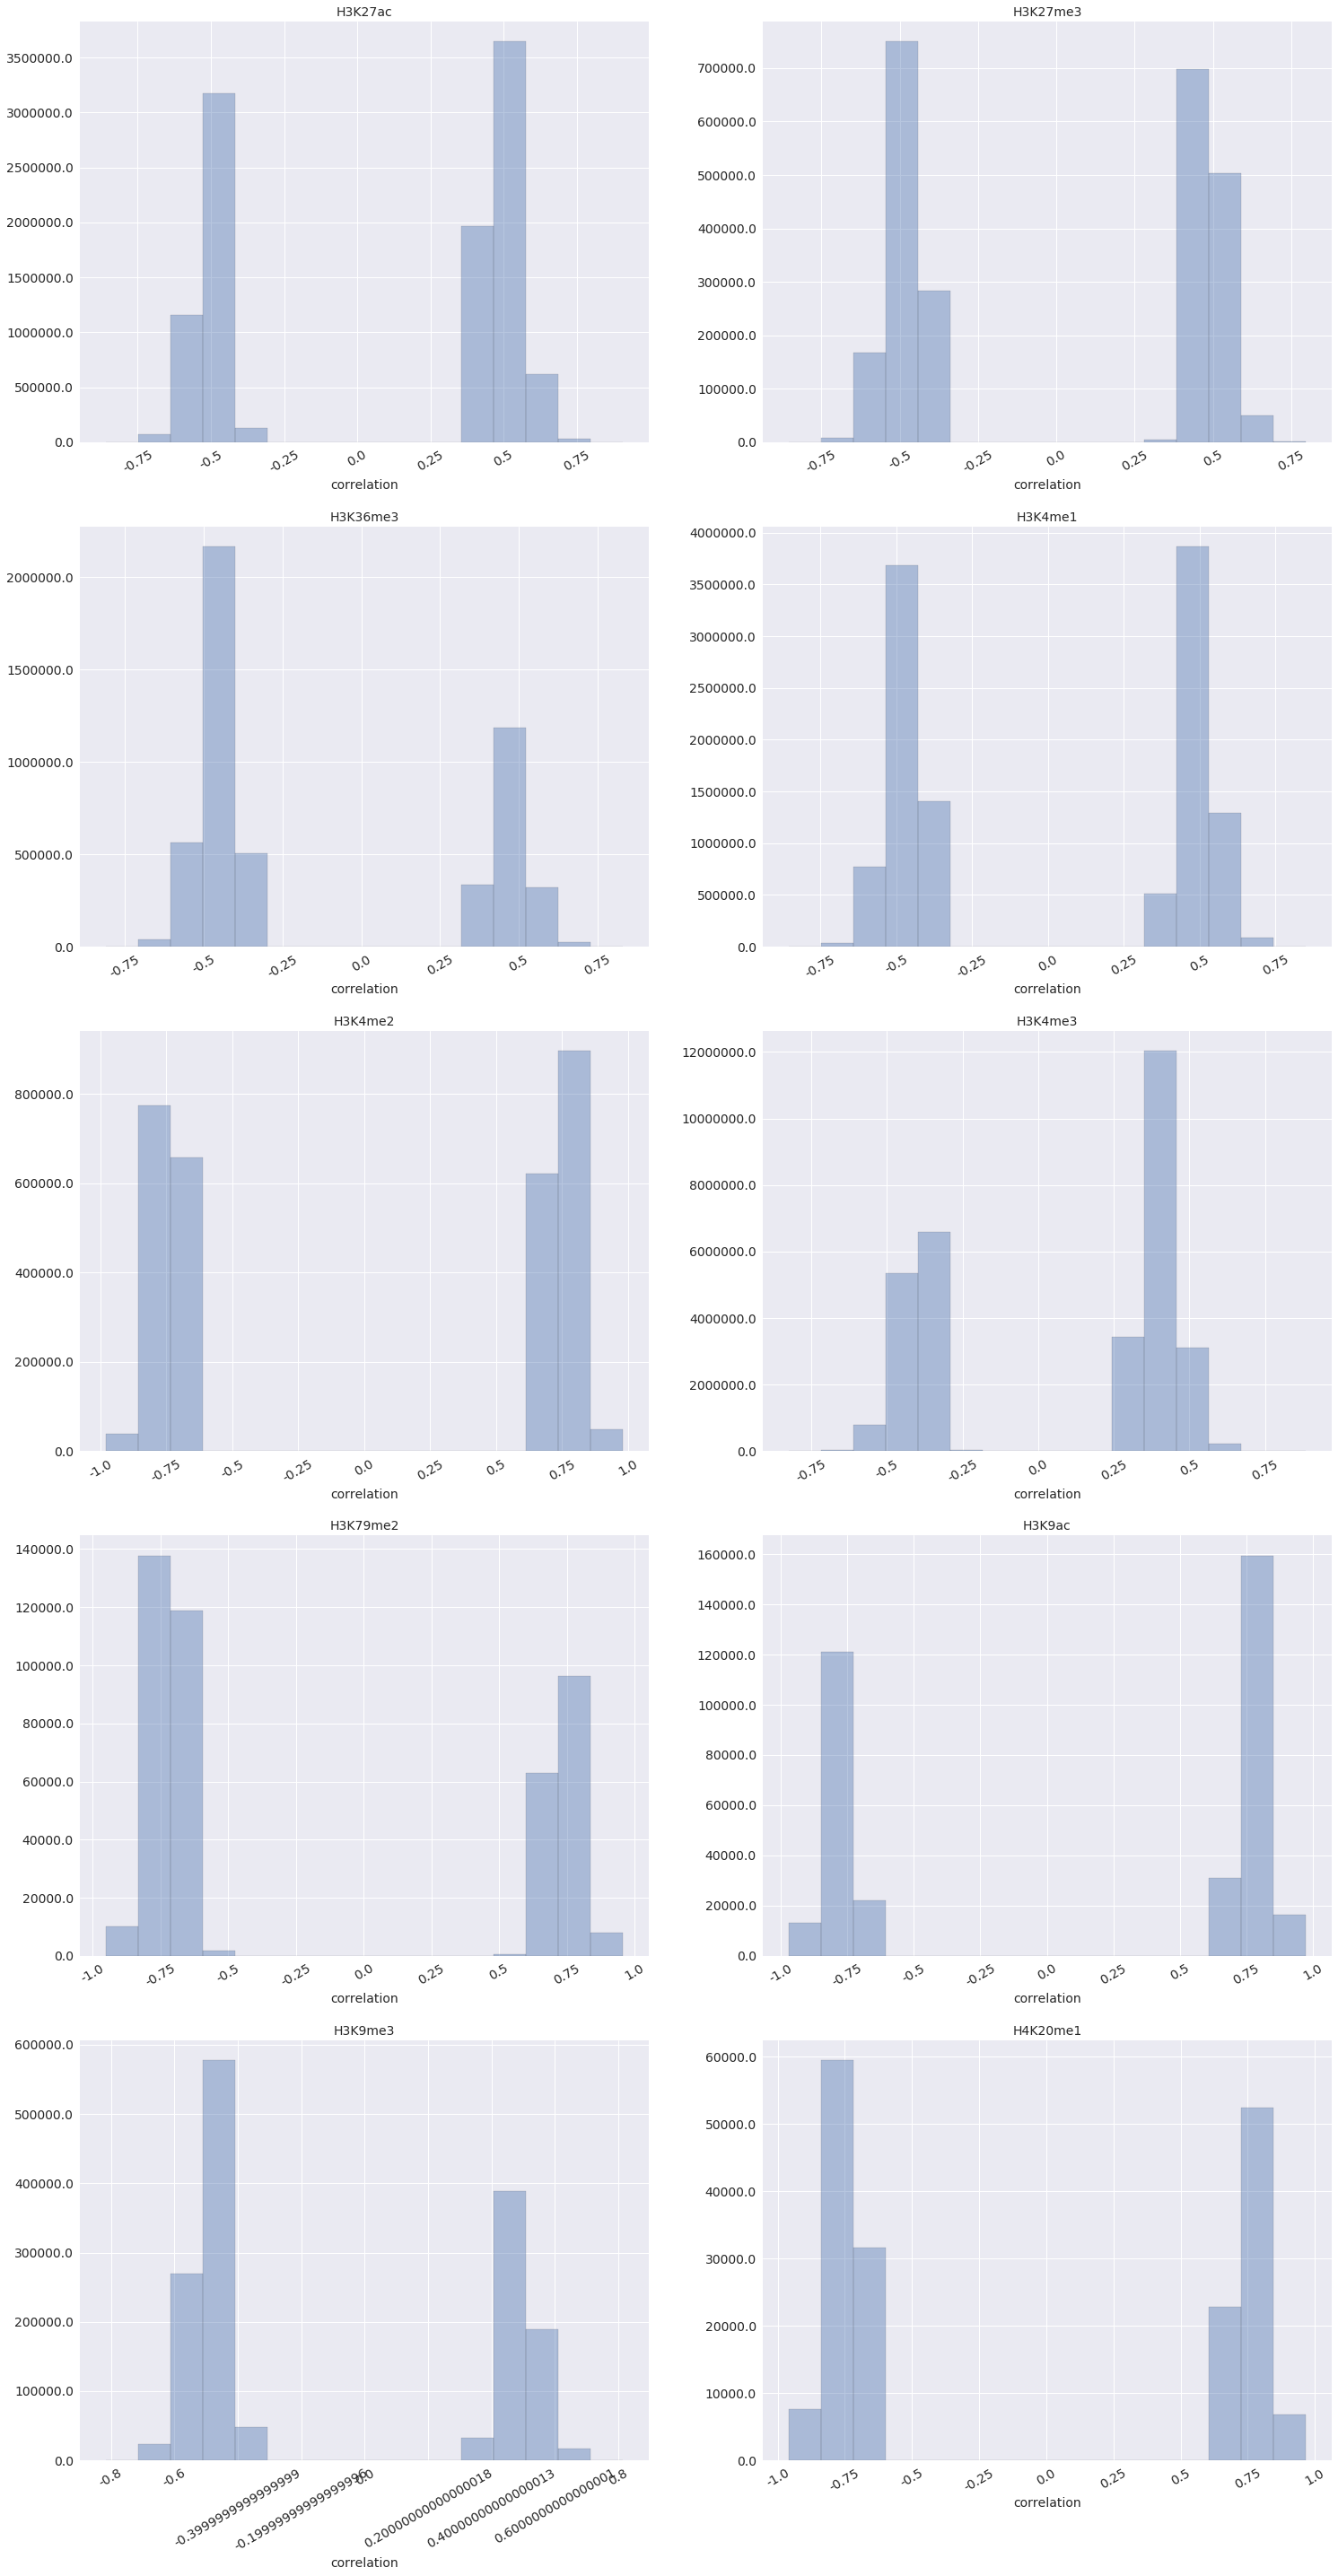

In [39]:
allMarksHists()

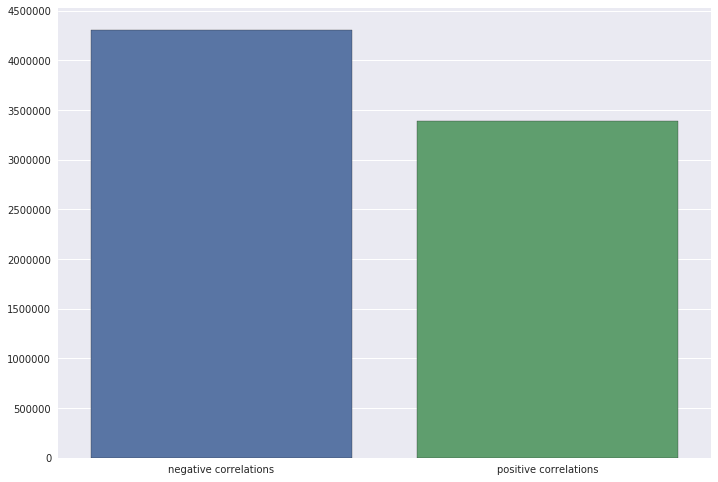

In [181]:
#barplot +/- correlations
def corrBarplot1():
    ax = sns.barplot(x=['negative correlations', 'positive correlations'], y=[4310512, 3391340])
    ax.set_yticks(range(0, 4500001, 500000))
    plt.show()
    
    fig = ax.get_figure()
    fig.patch.set_alpha(0)
    fig.savefig("../H3K27me3/plots/MakeLncRNAWithPeaksCorrelations_correlations_sign_barplot.png", bbox_inches='tight', pad_inches = 0)

/home/mazurovev/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


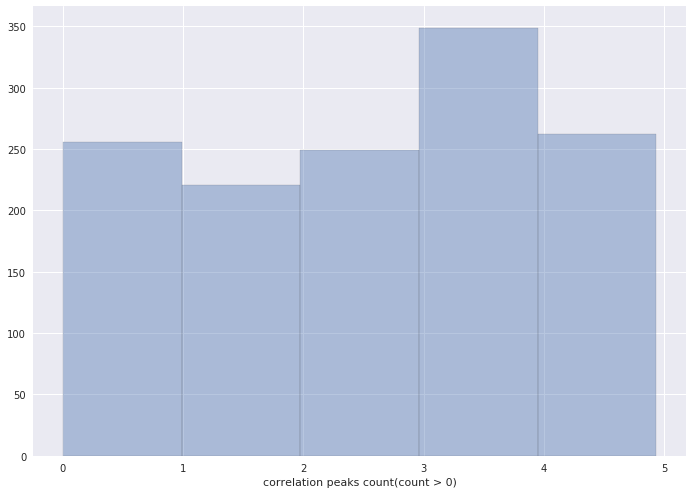

In [17]:
def peaksCountLog10Hist():
    ax = sns.distplot(np.log10([len(c) for c in corr if len(c) > 0]), bins=5, kde=False)
    #ax.set_xticks(range(0, 80000, 10000))
    ax.set(xlabel='correlation peaks count(count > 0)')
    plt.show()
    
    fig = ax.get_figure()
    fig.patch.set_alpha(0)
    fig.savefig("../H3K27me3/plots/MakeLncRNAWithPeaksCorrelations_peaks_count_hist.png", bbox_inches='tight', pad_inches = 0)

In [ ]:
#TODO: построить такой график только для пиков в генах и сравнить с фантомом

In [ ]:
def getAnno():
    return pd.read_csv("../H3K27me3/peaks/anno_merged_peaks.csv", sep="\t", header=None)

/home/mazurovev/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


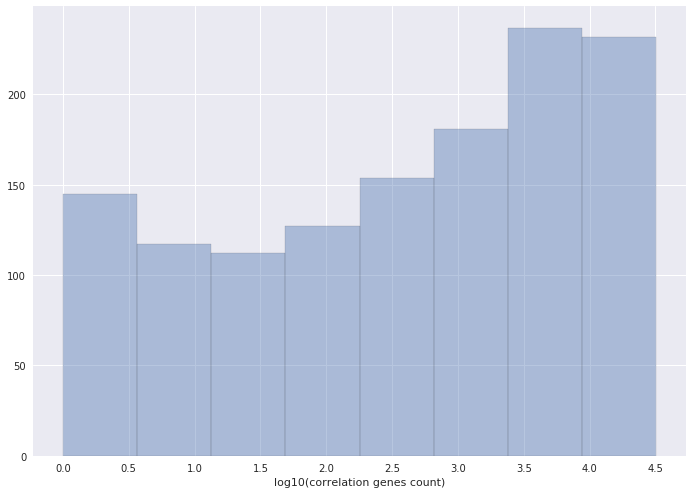

In [35]:
def plotCorrGenesCountLog10Hist():
    df = pd.read_csv("../H3K27me3/peaks/lncRNA_peaks_gene_association.tsv", sep="\t")
    d = {}
    i = 1
    lncRNAs = df['lncRNA'].unique()
    for r in lncRNAs:
        print(str(i))
        d[r] = len(df[df['lncRNA'] == r]['gene'].unique())
        i = i + 1
    
    ax = sns.distplot(np.log10(list(d.values())), bins=8, kde=False)
    ax.set_xticks(np.arange(0, 5, 0.5))
    ax.set(xlabel='log10(correlation genes count)')
    plt.show()
    
    fig = ax.get_figure()
    fig.patch.set_alpha(0)
    fig.savefig("../H3K27me3/plots/MakeLncRNAWithPeaksCorrelations_genes_count_log_10_hist.png", bbox_inches='tight', pad_inches = 0)

In [ ]:
#Есть ли уникальные пары?(график)

In [ ]:
#График где выше корреляция, у пиков рядом с генами или нет? в промоторах? или никакой разницы?

In [ ]:
#Deprecated
def corrForLncRNA(lncRNA):
    print(lncRNA[0] + ", " + str(lncRNA[2]))
    corr = []
    for i, r in chip.iterrows():
        corr.append((lncRNA[0], i, stats.spearmanr(lncRNA[1], r)))
        
    pvalues = [sr[1] for g, p, sr in corr]
    adjustedPvalues = multipletests(pvalues, alpha=0.05, method='fdr_bh')
    corr_corrected_significance = [i for i, j in zip(corr, adjustedPvalues[1]) if j < 0.05]
    
    return corr, corr_corrected_significance

In [ ]:
#====================

In [9]:
pd.read_csv("../all_marks/H3K27me3/our_fantom_genes_association.tsv", sep="\t")

lncRNAId     lncRNAName   our  our_p  our_m  fantom  fantom_p  \
0   ENSG00000212978     AC016747.3  2847   1423   1542     956       405   
1   ENSG00000260032      LINC00657    95     30     65    1192       532   
2   ENSG00000223485   RP11-417E7.1    32     14     18    6640      3348   
3   ENSG00000253161  RP11-150O12.1  1957    520   1465    1928       941   
4   ENSG00000260565       ERVK13-1   363     98    268      18         1   
5   ENSG00000225791      TRAM2-AS1   989    654    340       4         1   
6   ENSG00000227053   RP11-395B7.4    63     31     32    3096      1313   
7   ENSG00000225733       FGD5-AS1    66     33     33    1232       489   
8   ENSG00000240875      LINC00886    28      6     22    1145       556   
9   ENSG00000234456      MAGI2-AS3   204     60    144      74         9   
10  ENSG00000234608   MAPKAPK5-AS1  4571   3331   1476    1920       780   
11  ENSG00000256268  RP11-221N13.3  1683    500   1204     693       316   
12  ENSG00000234546   RP3-510D11.2  1378    772    628     362        93   
13  ENSG00000246430      LINC00968    60      8     52    1330       540   
14  ENSG00000214548           MEG3    39      9     30    3189      1954   
15  ENSG00000231185     AC005592.2     2      1      1    2043       868   
16  ENSG00000233396  RP11-458D21.1  2977   2316    715    7402      3449   
17  ENSG00000215039       CD27-AS1    12      4      8    1277       551   
18  ENSG00000273015      LINC00938   201     98    103     188       121   
19  ENSG00000257219    RP11-54A9.1  1283    676    634     231        67   
20  ENSG00000253982   CTD-2336O2.1   761     96    671       2         0   
21  ENSG00000246273       SBF2-AS1   250     51    199    1149       496   
22  ENSG00000229647     AC007879.7   942    438    517      97        26   

    fantom_m  intersection  mm_intersection  mp_intersection  pm_intersection  \
0        551           181               83               31               44   
1        674             3                3                0                0   
2       3706            14                6                2                4   
3        987           230              104               85               20   
4         17             1                0                0                1   
5          3             1                1                0                0   
6       1816            11                6                2                2   
7        748             2                1                0                1   
8        594             1                0                0                0   
9         65             3                2                0                1   
10      1160           531              205               39              208   
11       378            79               45               20                4   
12       269            16                8                1                7   
13       790             7                7                0                0   
14      1358             5                1                4                0   
15      1196             1                1                1                0   
16      3954          1161              199              108              285   
17       726             1                1                0                0   
18        67             2                0                0                2   
19       164            19               10                4                3   
20         2             1                1                0                0   
21       653            21               15                1                5   
22        71             5                4                1                0   

    pp_intersection  
0                29  
1                 0  
2                 2  
3                22  
4                 0  
5                 0  
6                 1  
7                 0  
8                 1  
9                 0  

In [10]:
pd.read_csv("../H3K27me3/our_fantom_genes_association.tsv", sep="\t")

lncRNAId      lncRNAName    our  our_plus  our_minus  fantom  \
0   ENSG00000233117       LINC00702    548       115        433    1491   
1   ENSG00000231312      AC007246.3  13047     11999       1925     608   
2   ENSG00000225439       BOLA3-AS1  12388     11187       2066    1679   
3   ENSG00000230074   RP11-195F19.9      3         0          3    3644   
4   ENSG00000267751      AC009005.2  10821      8877       3194      23   
5   ENSG00000260565        ERVK13-1  10025      3349       7670      18   
6   ENSG00000231187    RP11-38L15.3    988        27        961    8516   
7   ENSG00000233901     RP11-65J3.1      1         0          1    4548   
8   ENSG00000245937    CTC-228N24.3    191        85        106      87   
9   ENSG00000214548            MEG3    768       113        657    3255   
10  ENSG00000240875       LINC00886     17         2         15    1160   
11  ENSG00000225733        FGD5-AS1     14        13          1    1254   
12  ENSG00000260032       LINC00657    258       107        151    1220   
13  ENSG00000247240        UBL7-AS1    163        37        126      15   
14  ENSG00000255121   RP11-110I1.12   7943      3081       5470       3   
15  ENSG00000227036       LINC00511     47        14         33     678   
16  ENSG00000246089   RP11-115C21.2   7551      6083       1933      32   
17  ENSG00000270141            TERC   2518       663       1898     182   
18  ENSG00000231185      AC005592.2  11270      6655       6306    2082   
19  ENSG00000223478   RP11-545E17.3   1822       932        929     405   
20  ENSG00000261879    RP11-333E1.1   5030       118       4917       4   
21  ENSG00000233396   RP11-458D21.1   1097       787        318    7571   
22  ENSG00000218510       LINC00339  11957     11372        797    1899   
23  ENSG00000245571      AP001258.4   4454      3880        632      59   
24  ENSG00000246430       LINC00968     32         4         28    1377   
25  ENSG00000271270       TMCC1-AS1    528       284        247    1109   
26  ENSG00000225377    RP5-1103G7.4   4400      3171       1483    5447   
27  ENSG00000229852  RP11-398K22.12      6         5          1    1114   
28  ENSG00000251580   RP11-539L10.3    693       282        414     205   
29  ENSG00000234608    MAPKAPK5-AS1   9167      7682       2126    1946   
30  ENSG00000226950           DANCR    662       532        132     342   
31  ENSG00000273015       LINC00938    423       337         86     190   
32  ENSG00000233527      AC092295.7   9228      4156       6257    6230   
33  ENSG00000246273        SBF2-AS1    390        39        351    1163   
34  ENSG00000246067       RAB30-AS1   4522      1551       3276    8781   
35  ENSG00000212978      AC016747.3   4933      1187       3930     980   
36  ENSG00000204054       LINC00963    589       488        106     944   

    fantom_plus  fantom_minus  intersection  minus_minus_intersection  \
0           827           664            44                        29   
1           224           384           426                        88   
2           810           869          1222                       221   
3          1658          2005             2                         2   
4             2            21            16                         7   
5             1            17            10                         5   
6          3701          4830           600                       429   
7          2051          2522             1                         1   
8            30            57             2                         2   
9          1989          1390           140                        38   
10          562           603             2                         0   
11          497           762             2                         0   
12          550           684            20                        14   
13            4            11             1                         1   
14            1             2             2                      